In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birdsembedded/birds/readme
/kaggle/input/birdsembedded/birds/example_captions.txt
/kaggle/input/birdsembedded/birds/test/filenames.pickle
/kaggle/input/birdsembedded/birds/test/char-CNN-RNN-embeddings.pickle
/kaggle/input/birdsembedded/birds/test/class_info.pickle
/kaggle/input/birdsembedded/birds/text_c10/037.Acadian_Flycatcher/Acadian_Flycatcher_0050_795608.txt
/kaggle/input/birdsembedded/birds/text_c10/037.Acadian_Flycatcher/Acadian_Flycatcher_0063_795585.txt
/kaggle/input/birdsembedded/birds/text_c10/037.Acadian_Flycatcher/Acadian_Flycatcher_0034_795583.txt
/kaggle/input/birdsembedded/birds/text_c10/037.Acadian_Flycatcher/Acadian_Flycatcher_0031_795582.txt
/kaggle/input/birdsembedded/birds/text_c10/037.Acadian_Flycatcher/Acadian_Flycatcher_0003_29094.txt
/kaggle/input/birdsembedded/birds/text_c10/037.Acadian_Flycatcher/Acadian_Flycatcher_0053_795620.txt
/kaggle/input/birdsembedded/birds/text_c10/037.Acadian_Flycatcher/Acadian_Flycatcher_0008_795599.txt
/kaggle/input/b

In [3]:
!pip install transformers

In [23]:
import os
import pickle
import random
import time
from time import time
import glob
import os

# Other NLP libraries
from textblob import TextBlob                                             
from sklearn.feature_extraction.text import TfidfVectorizer               
import re                                                                 
import nltk                                                               
nltk.download('punkt') 

import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math


# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
seed = 42
colormap = 'cividis'
template = 'plotly_dark'

In [5]:
def load_caption(file_path):
    filename_path = file_path + "/filenames.pickle"
    with open(filename_path, 'rb') as file:
        filenames = pickle.load(file, encoding='latin1')
        filenames = np.array(filenames)
    captions = np.zeros((len(filenames), 10), dtype='U256')
    caption_text=[]
    for filename in filenames:
        file ='/kaggle/input/birdsembedded/birds/text_c10/'+filename+'.txt'
        with open(file, 'r') as t:
            lines = t.readlines()
            caption_text.append(lines)
    for i in range(len(caption_text)):
        captions[i]=caption_text[i]
    df = pd.DataFrame(captions)
    df.insert(loc=0, column='File path', value=filenames)
    return df,captions

In [6]:
file_train_path='/kaggle/input/birdsembedded/birds/train'
file_test_path='/kaggle/input/birdsembedded/birds/test'

In [7]:
df_train,train_captions=load_caption(file_train_path)
df_test,test_captions=load_caption(file_test_path)

In [11]:
pd.set_option('display.max_colwidth', 1000)

In [13]:
df_train.head()

File path  \
0  002.Laysan_Albatross/Laysan_Albatross_0002_1027   
1  002.Laysan_Albatross/Laysan_Albatross_0003_1033   
2   002.Laysan_Albatross/Laysan_Albatross_0082_524   
3   002.Laysan_Albatross/Laysan_Albatross_0044_784   
4   002.Laysan_Albatross/Laysan_Albatross_0070_788   

                                                                                                             0  \
0                                                 a bird with a very long wing span and a long pointed beak.\n   
1                                      the bird has webbed feet that are pale pink as well as skinny tarsus.\n   
2                       the large bird has a white neck, black body, and a long yellow beak curved downward.\n   
3                    this bird is colored brown on its wings and back while its head and rump are all white.\n   
4  a large bird with white head and brown wing bars and a long narrow yellow beak that is hooked at the end.\n   

                                                                                                                                1  \
0                                                                  the long-beaked bird has a white body with long brown wings.\n   
1       a large sea bird with blue feat and a large orange bill. it's body and head are white and wings are dark grey to black.\n   
2  this larger sized bird has a long, white neck, brownish black wings and tail feathers and an orange beak that tips downward.\n   
3                                                     a bird diving with a yellow beak, brown wings, and a white head and neck.\n   
4                                                             a white albatross with brown wings and a peach colored bony beak.\n   

                                                                                                                                             2  \
0                                                                             this is a white bird with brown wings and a large pointy beak.\n   
1                                                                        this white bird has a long, curved-at-the-end beak and webbed feet.\n   
2  a large bird with white feathers covering its head, neck and throat, with a grey cheek, and brown feathers covering the rest of its body.\n   
3                                                                      the bird with big black wings, white crown and head, and brown breast\n   
4                    this bird has a long orange and black beak, with black spots around its eyes and a brown back, with a basic white head.\n   

                                                                                                                                                  3  \
0                                                           this large bird has long bill, a white breast, belly & head and a black back & wings.\n   
1  this large sea bird is white with black wings, has a long orange bill that curves downward at the end with a black tip, and its feet are pink.\n   
2                                                                             medium to large grey and white bird with long orange and black beak\n   
3                                                                                  this is a large brown bird with a white rump and a white head.\n   
4                                                                                            this bird has a white breast and a really long bill.\n   

                                                                                       4  \
0      bird has an extremely long wingspan with a darker top and white belly and head.\n   
1                         this bird has a white crown, a long neck, and an orange bill\n   
2  this bird is white and black in color with a long curved beak, and black eye rings.\n   
3         this bird is white and brown in color with a long beak, and white eye 

In [30]:
def describe_df(df):
    
    global categorical_features
    categorical_features = [col for col in df.columns if df[col].dtype == 'object']

In [24]:
def histogram_boxplot(df,hist_color, box_color, height, width, legend, name):
    
    features = df.select_dtypes(include = [np.number]).columns.tolist()

    for feat in features:
        try:
            fig = make_subplots(
                rows=1,
                cols=2,
                subplot_titles=["Box Plot", "Histogram"],
                horizontal_spacing=0.2
            )

            density = gaussian_kde(df[feat])
            x_vals = np.linspace(min(df[feat]), max(df[feat]), 200)
            density_vals = density(x_vals)

            fig.add_trace(go.Scatter(x=x_vals, y = density_vals, mode = 'lines',
                                     fill = 'tozeroy', name="Density", line_color=hist_color), row=1, col=2)
            fig.add_trace(go.Box(y=df[feat], name="Box Plot", boxmean=True, line_color=box_color), row=1, col=1)

            fig.update_layout(title={'text': f'<b>{name} Word Count<br><sup><i>&nbsp;&nbsp;&nbsp;&nbsp;{feat}</i></sup></b>',
                                     'x': .025, 'xanchor': 'left'},
                             margin=dict(t=100),
                             showlegend=legend,
                             template = template,
                             #plot_bgcolor=bg_color,paper_bgcolor=paper_color,
                             height=height, width=width
                            )

            fig.update_yaxes(title_text=f"<b>Words</b>", row=1, col=1, showgrid=False)
            fig.update_xaxes(title_text="", row=1, col=1, showgrid=False)

            fig.update_yaxes(title_text="<b>Frequency</b>", row=1, col=2,showgrid=False)
            fig.update_xaxes(title_text=f"<b>Words</b>", row=1, col=2, showgrid=False)

            fig.show()
            print('\n')
        except Exception as e:
            print(f"An error occurred: {e}")

In [28]:
df=df_train.drop(columns='File path',axis=1)

In [31]:
describe_df(df)

In [32]:
categorical_features

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

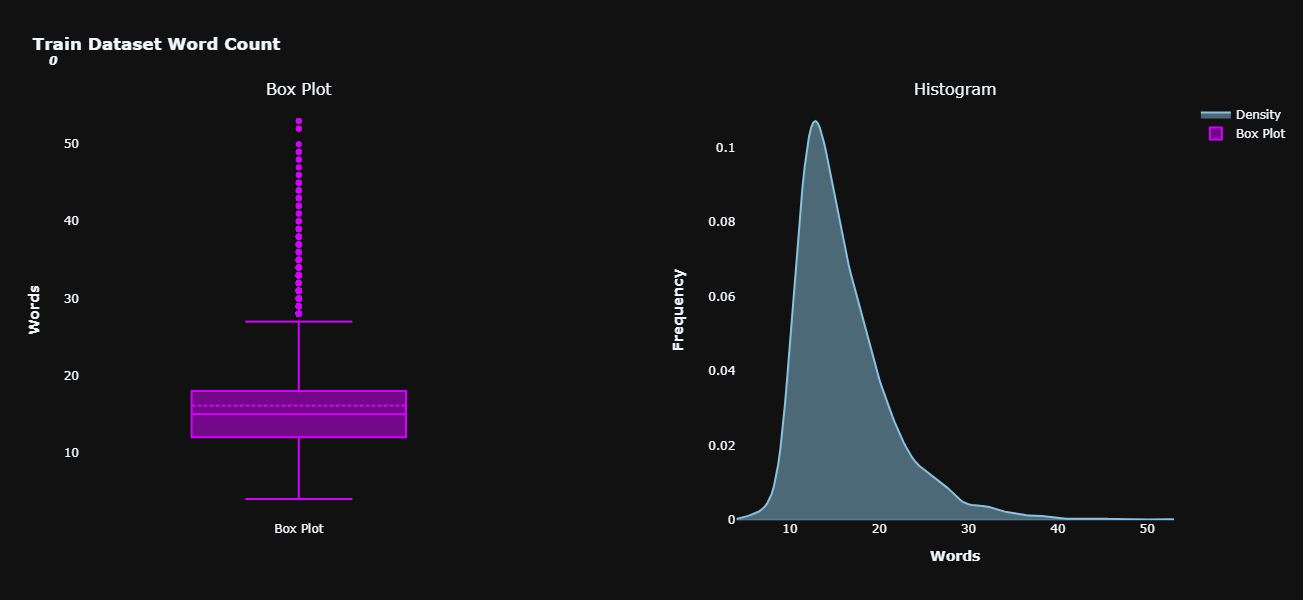

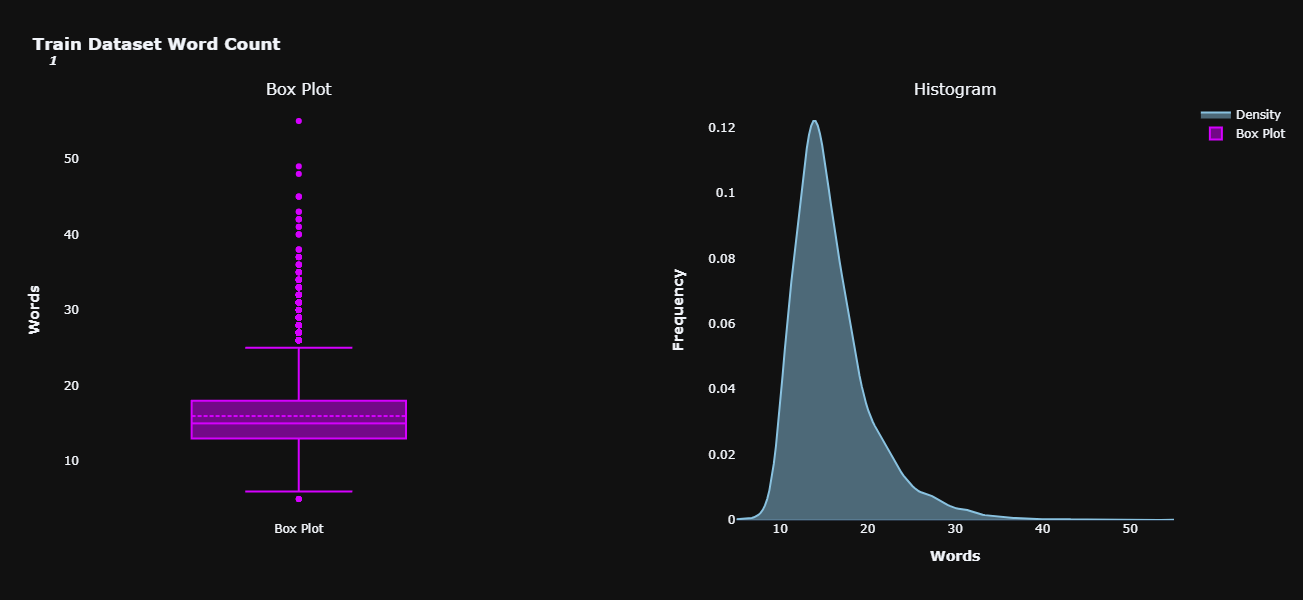

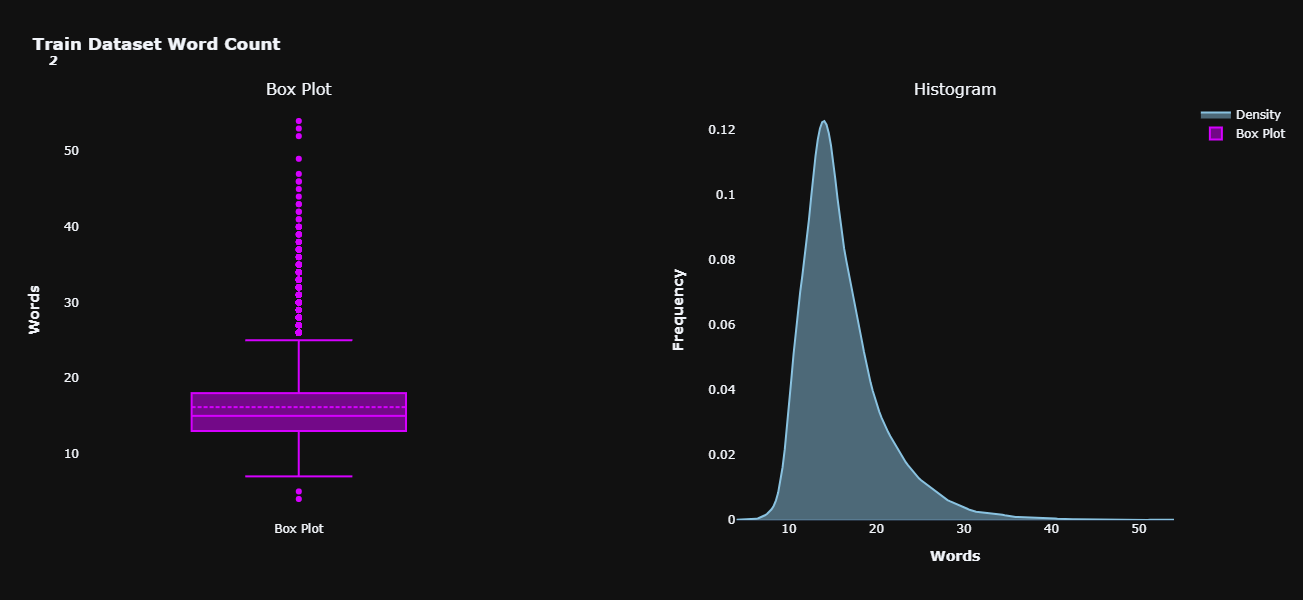

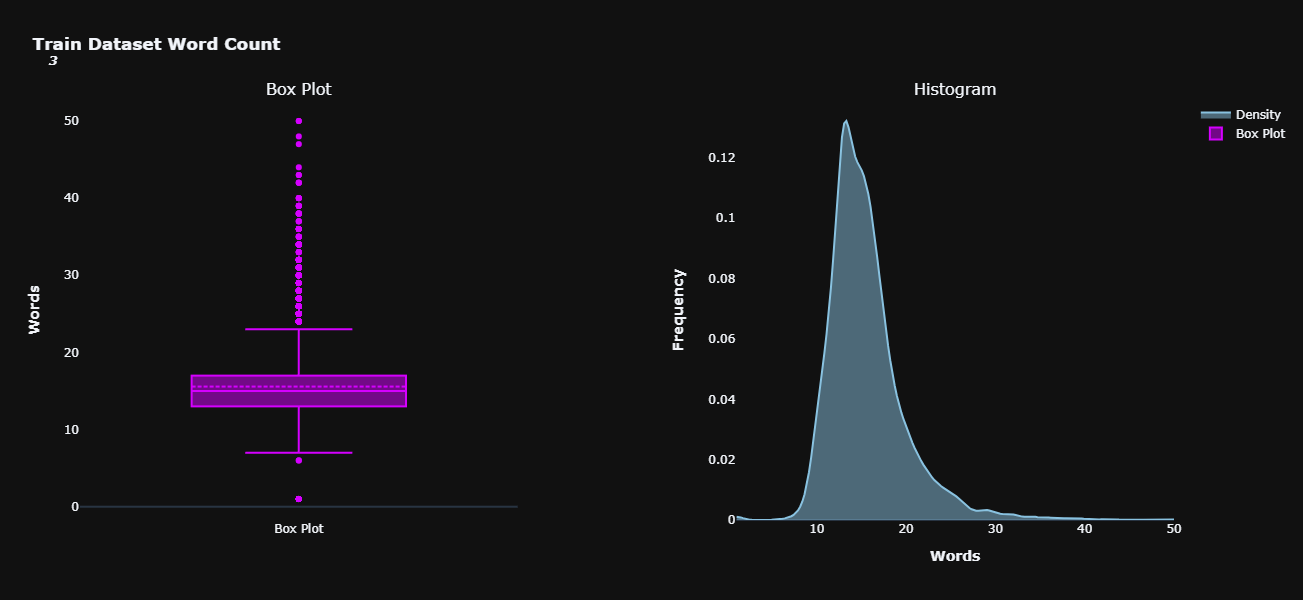

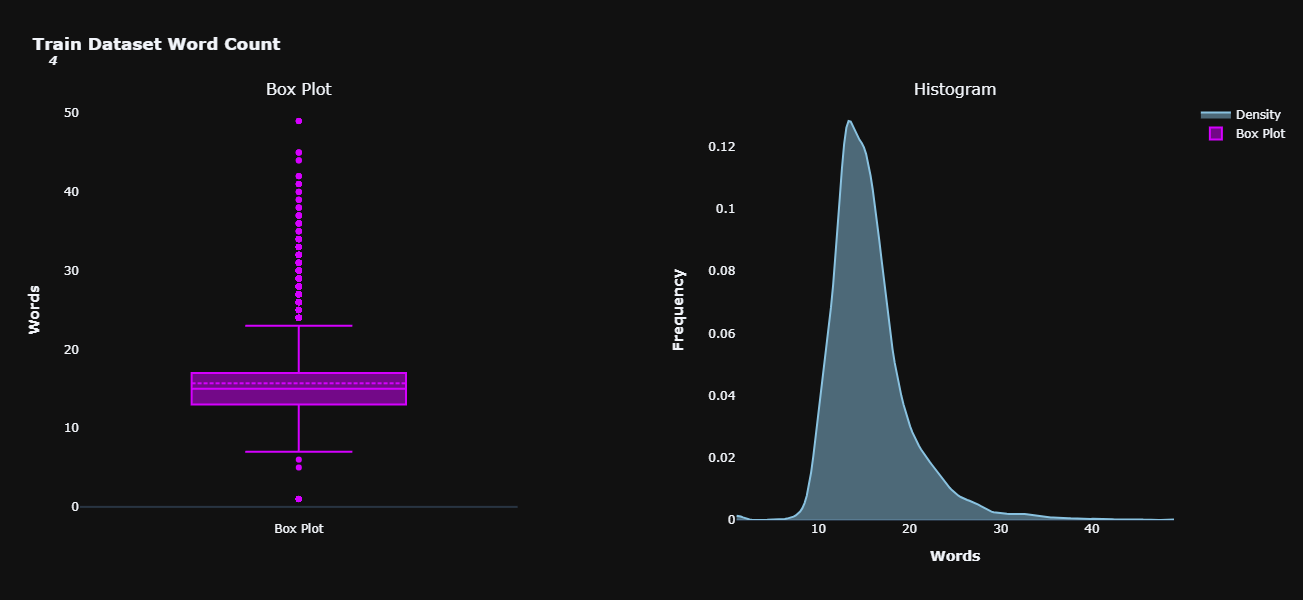

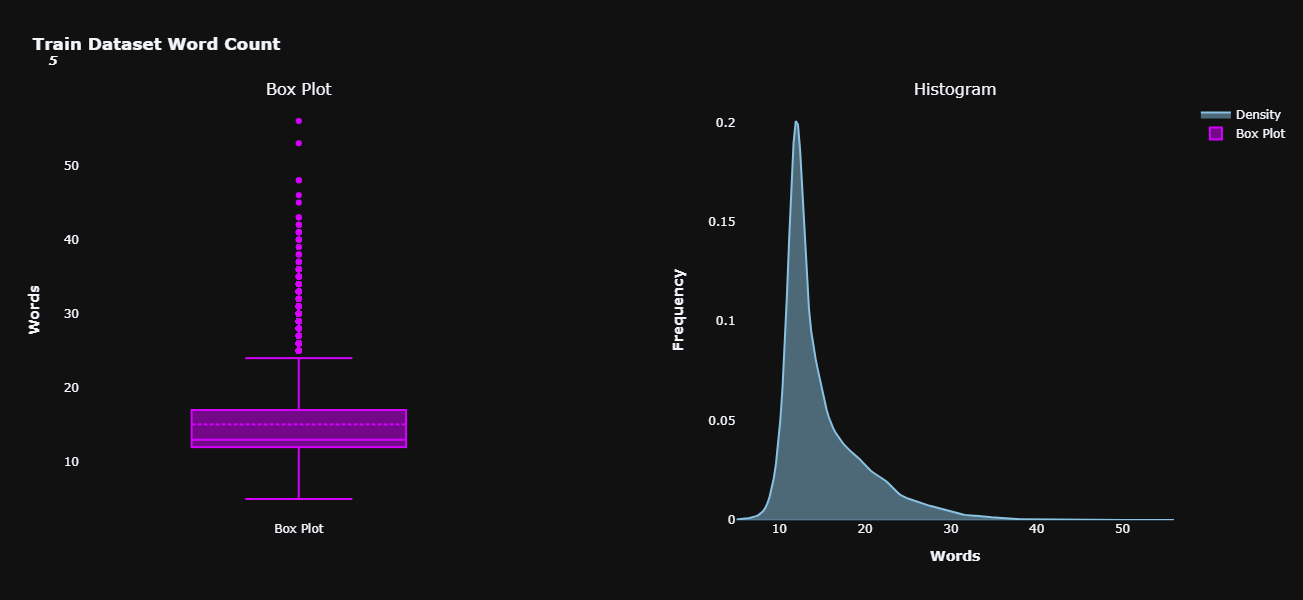

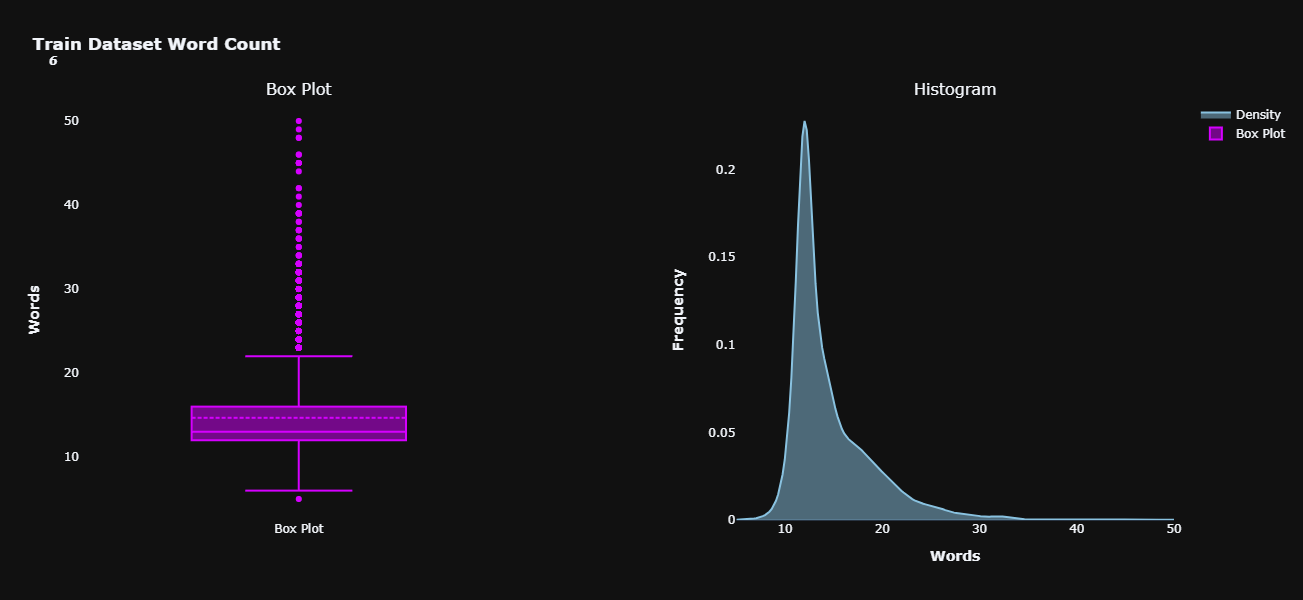

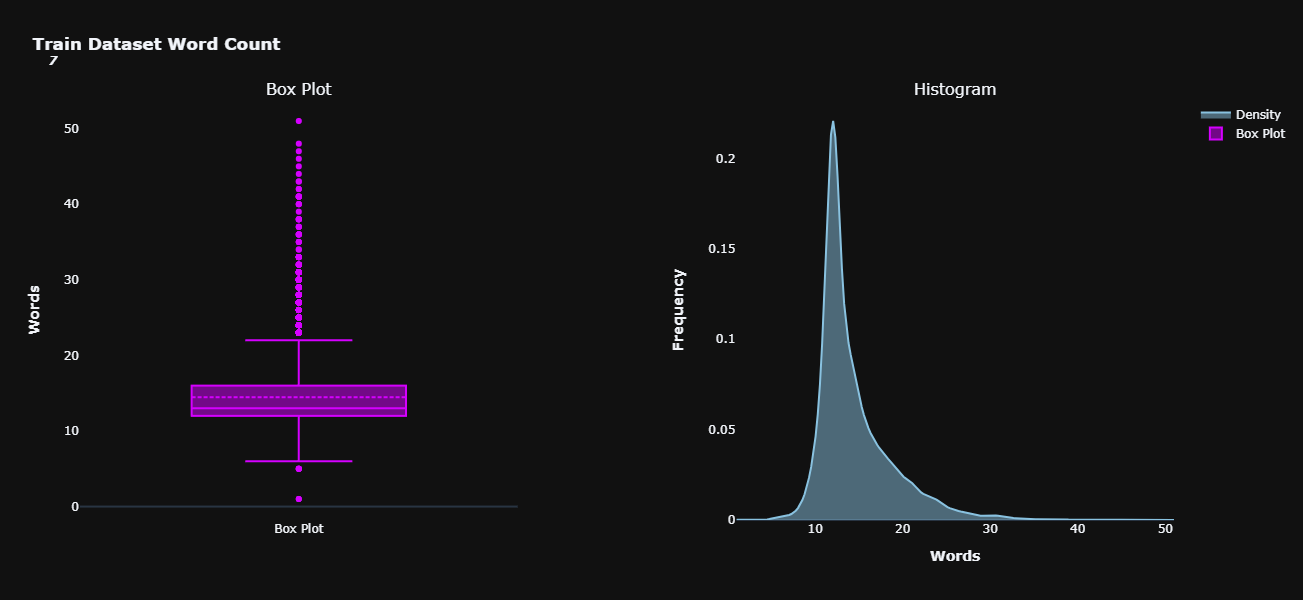

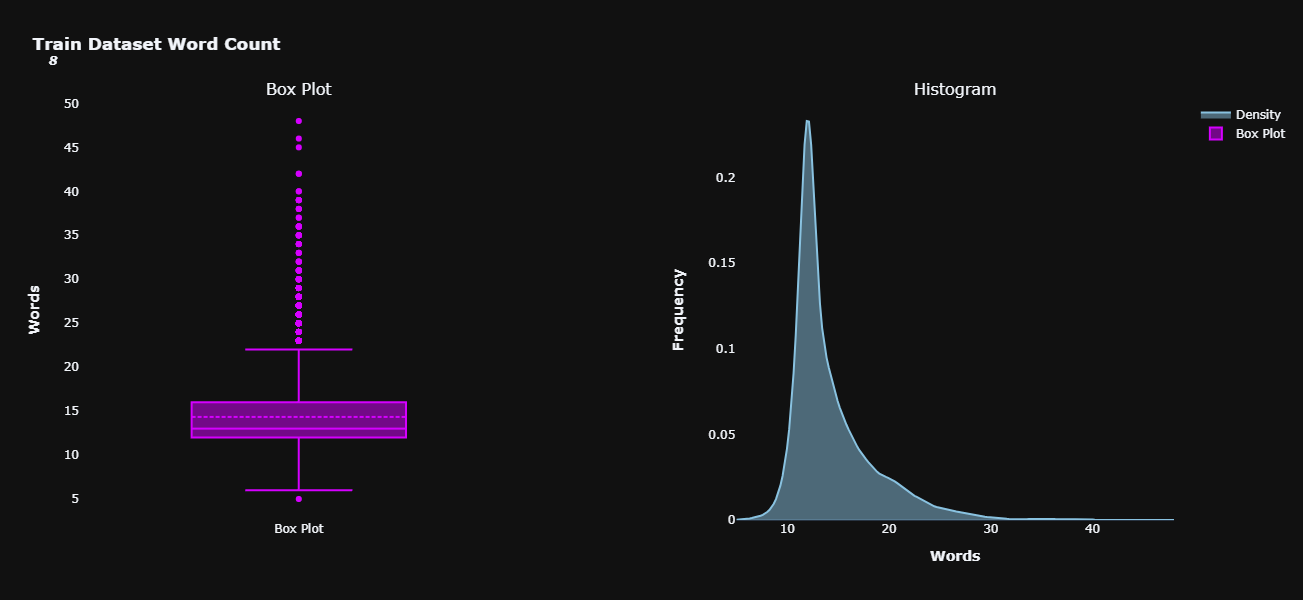

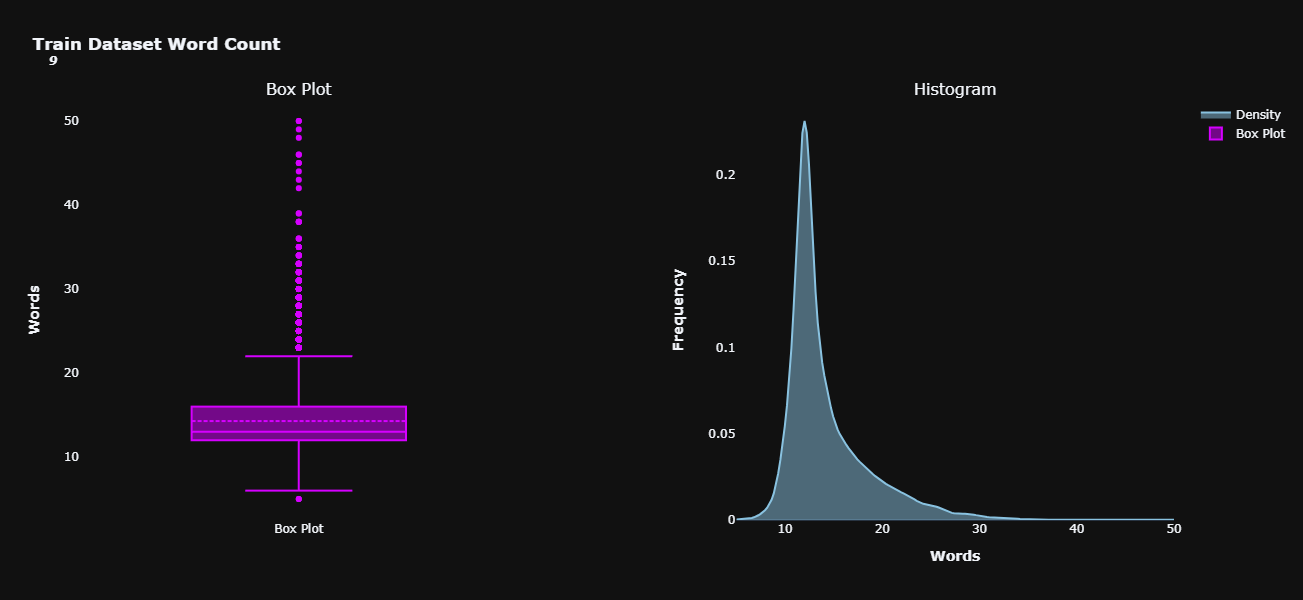

In [33]:
df_text_lenght = pd.DataFrame() # Creating an empty dataframe
for feat in categorical_features: # Iterating through features --> Dialogue & Summary
    df_text_lenght[feat] = df_train[feat].apply(lambda x: len(str(x).split())) #  Counting words for each feature

# Plotting histogram-boxplot
histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Train Dataset')

In [46]:
def plot_correlation(df, title, subtitle, height, width, font_size):
    '''
    This function is resposible to plot a correlation map among features in the dataset.

    Parameters:
    height = Define height
    width = Define width
    font_size = Define the font size for the annotations
    '''
    corr = np.round(df.corr(numeric_only = True), 2)
    mask = np.triu(np.ones_like(corr, dtype = bool))
    c_mask = np.where(~mask, corr, 100)

    c = []
    for i in c_mask.tolist()[1:]:
        c.append([x for x in i if x != 100])



    fig = ff.create_annotated_heatmap(z=c[::-1],
                                      x=corr.index.tolist()[:-1],
                                      y=corr.columns.tolist()[1:][::-1],
                                      colorscale = colormap)

    fig.update_layout(title = {'text': f"<b>{title} Heatmap<br><sup>&nbsp;&nbsp;&nbsp;&nbsp;<i>{subtitle}</i></sup></b>",
                                'x': .025, 'xanchor': 'left', 'y': .95},
                    margin = dict(t=210, l = 110),
                    yaxis = dict(autorange = 'reversed', showgrid = False),
                    xaxis = dict(showgrid = False),
                    template = template,
                    #plot_bgcolor=bg_color,paper_bgcolor=paper_color,
                    height = height, width = width)


    fig.add_trace(go.Heatmap(z = c[::-1],
                             colorscale = colormap,
                             showscale = True,
                             visible = False))
    fig.data[1].visible = True

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = font_size

    fig.show()

In [35]:
def compute_tfidf(df_column, ngram_range=(1,1), max_features=15):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=ngram_range)
    x = vectorizer.fit_transform(df_column.fillna(''))
    df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
    return df_tfidfvect

In [50]:
f"Unigrams, Train - caption - {0}"

'Unigrams, Train - caption - 0'

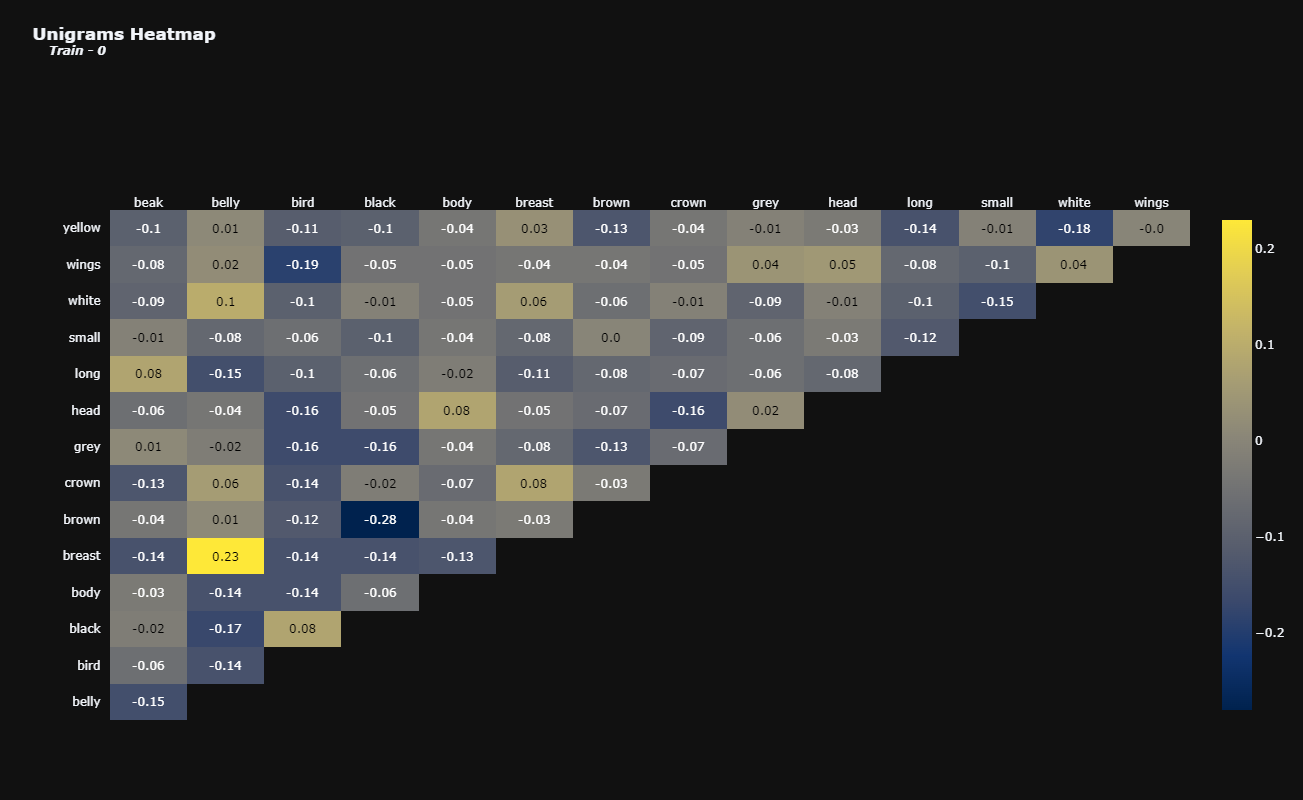

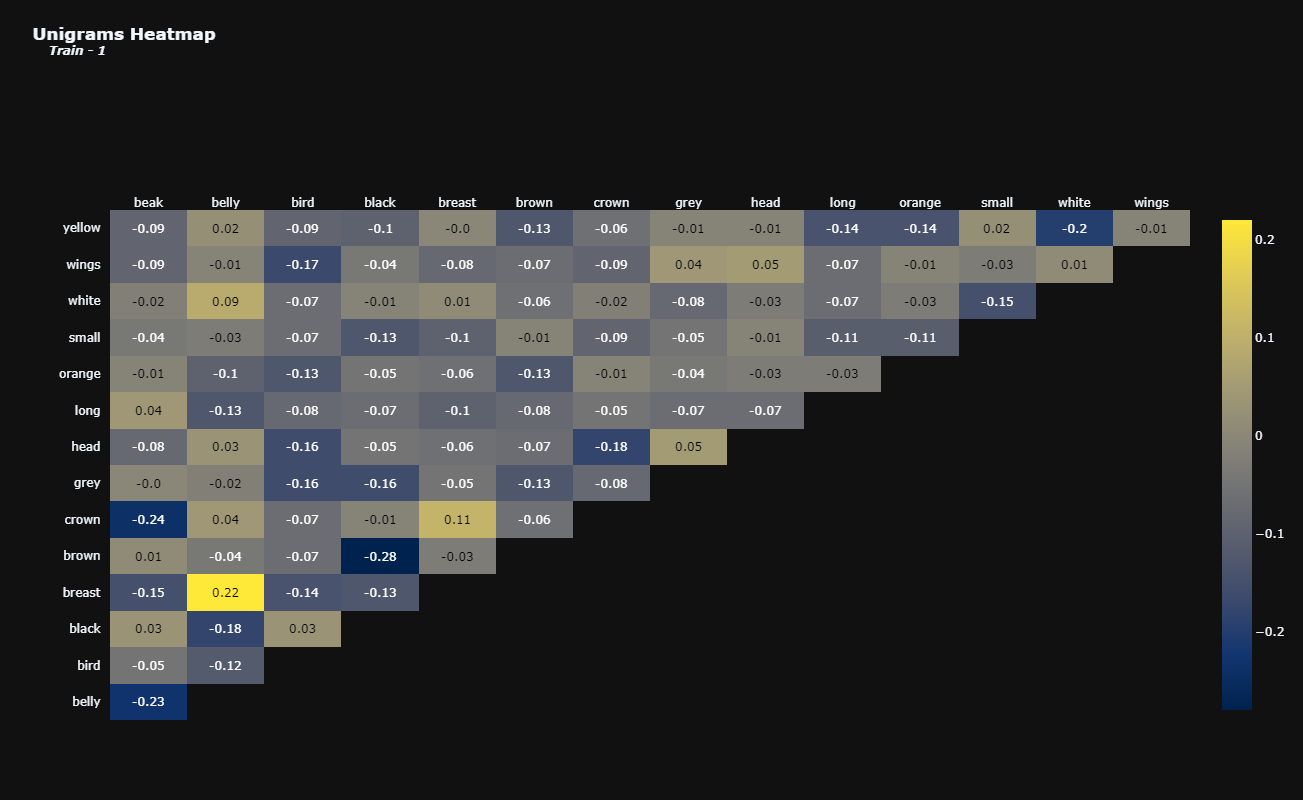

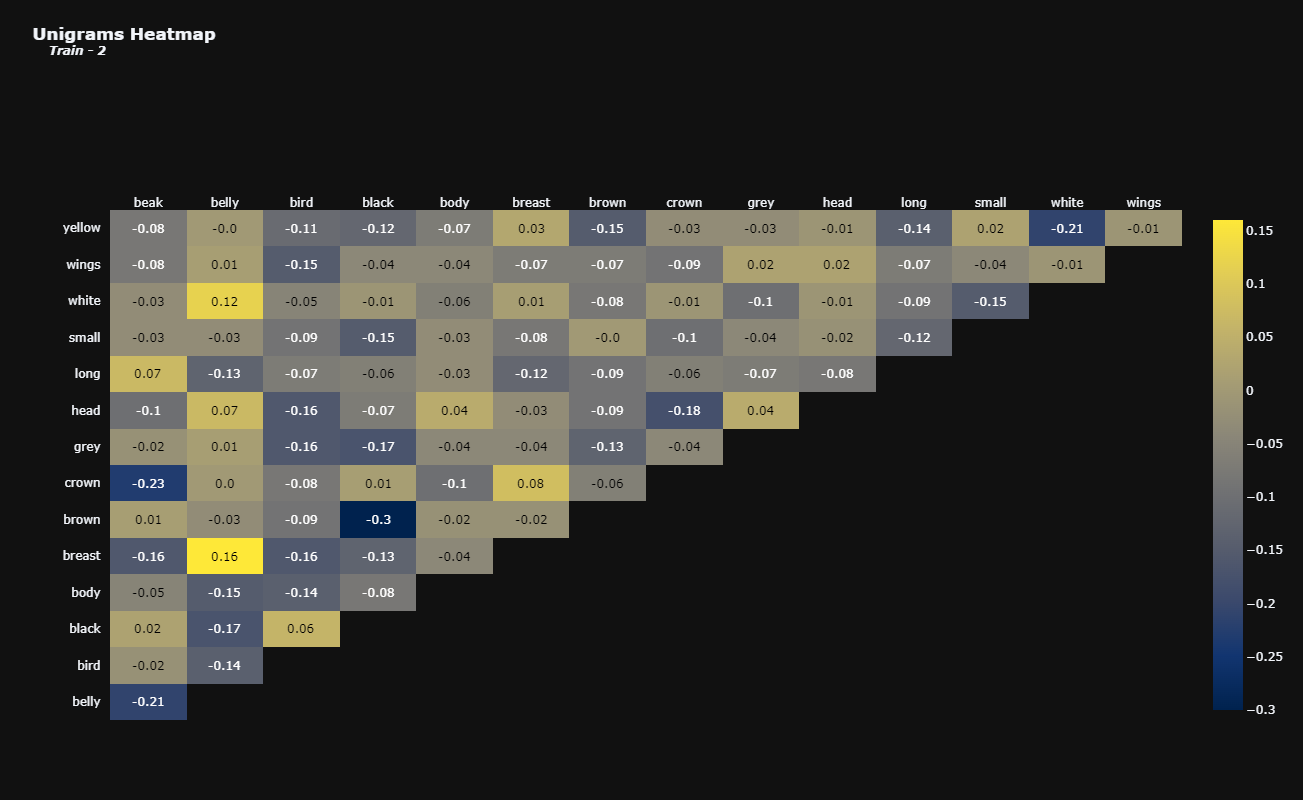

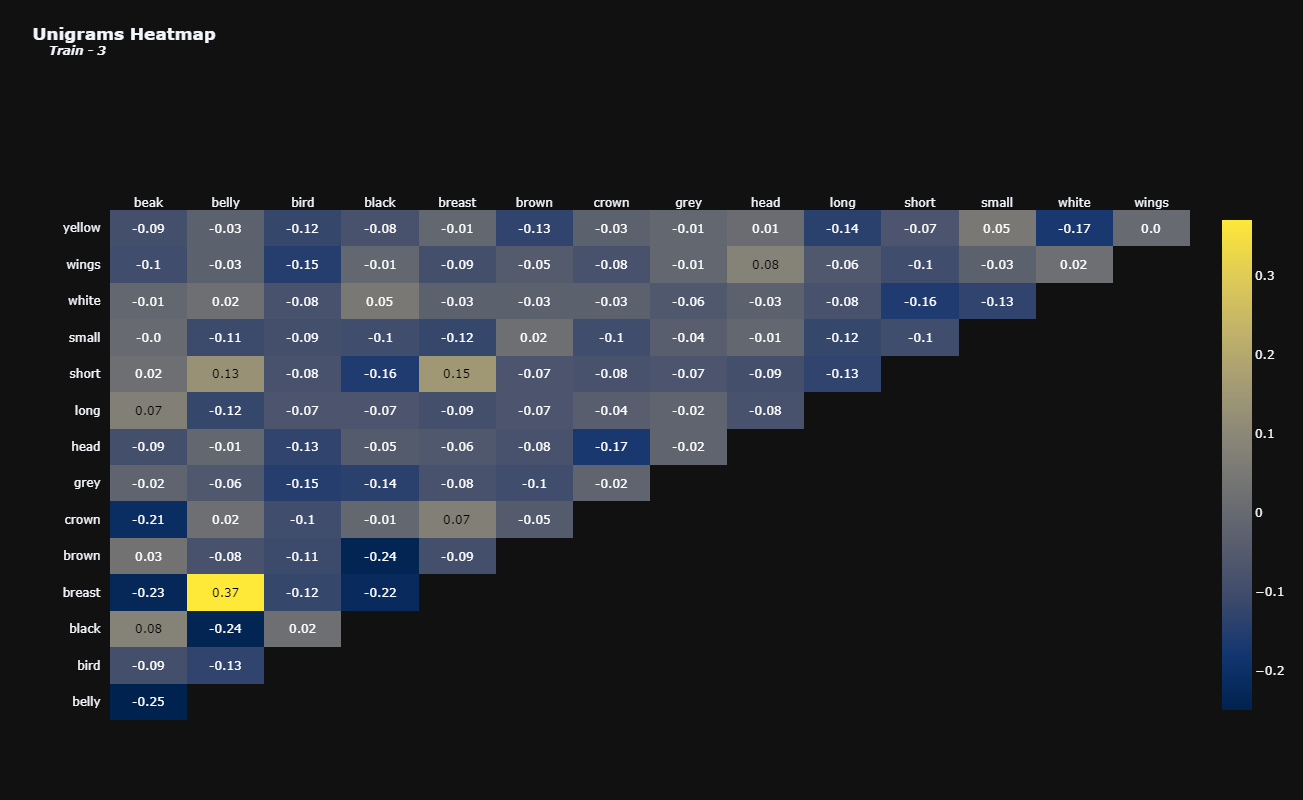

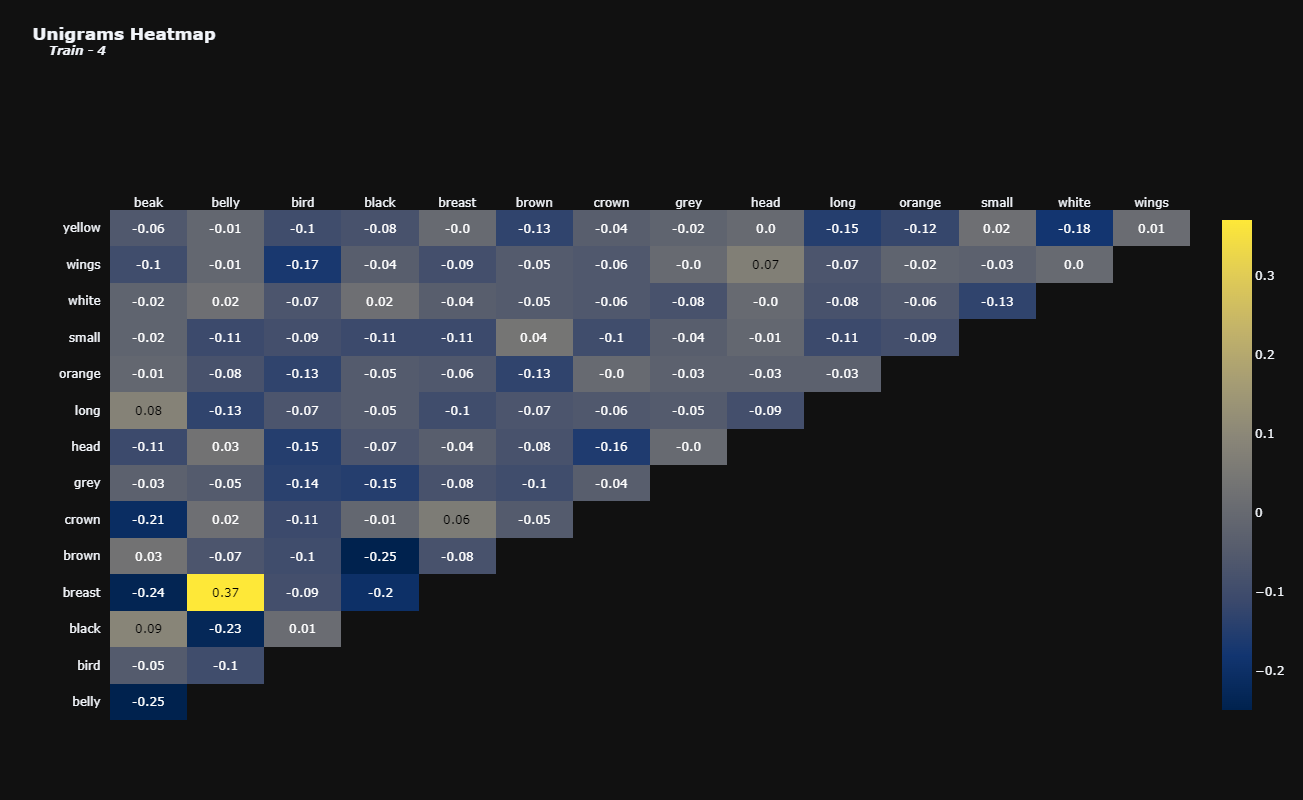

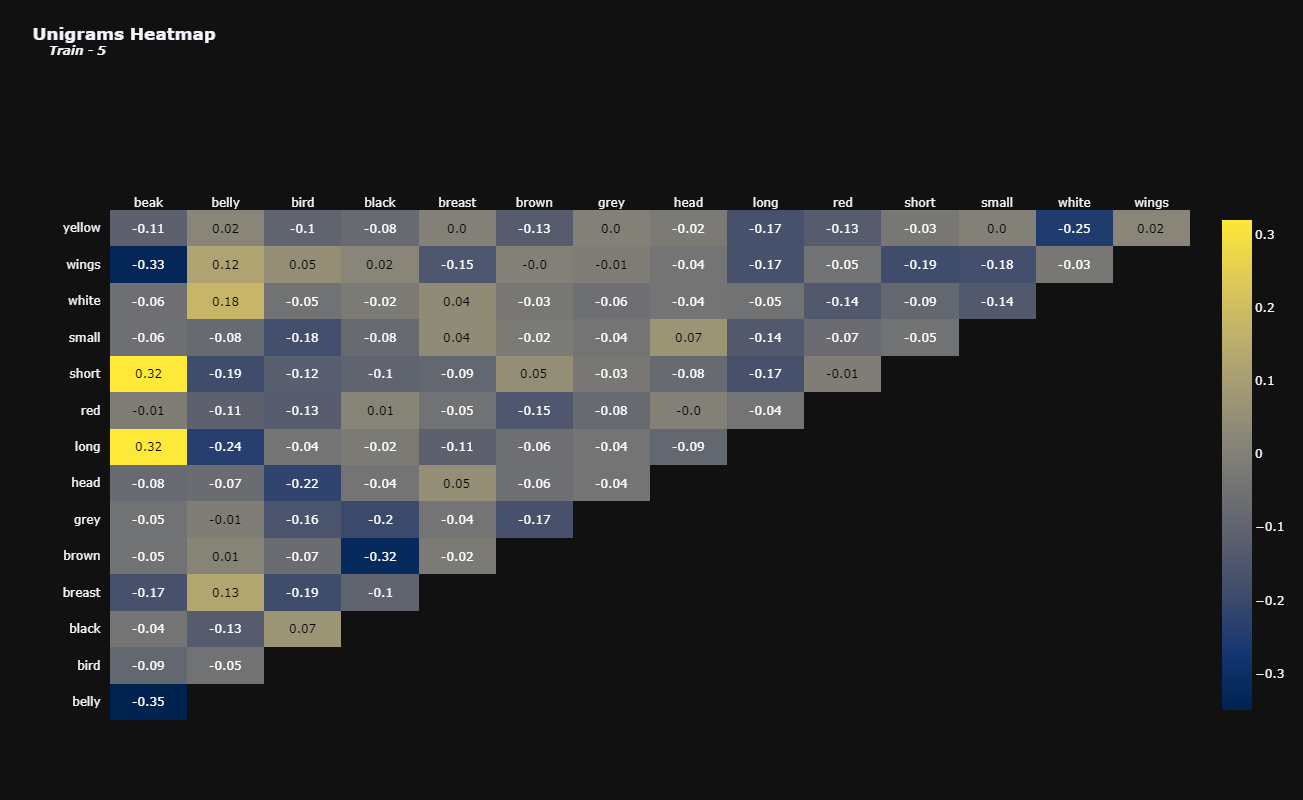

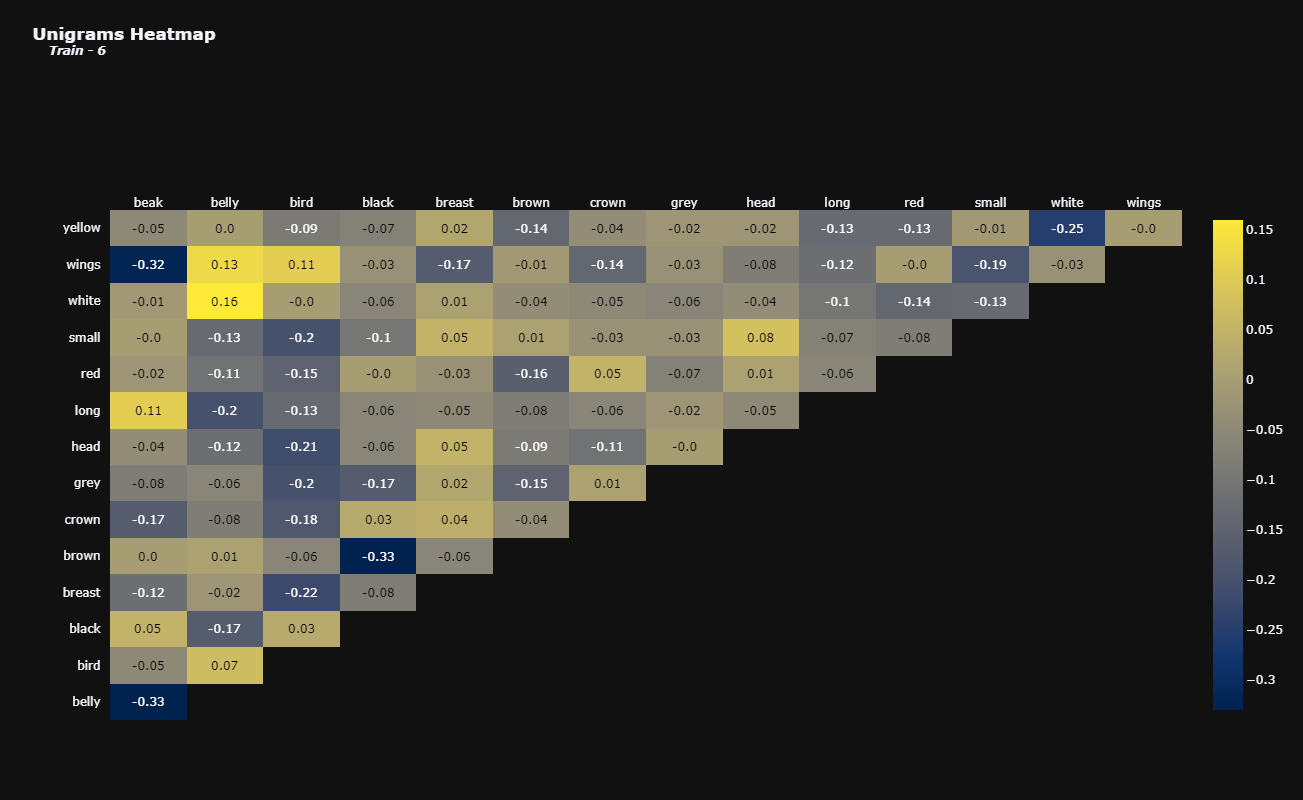

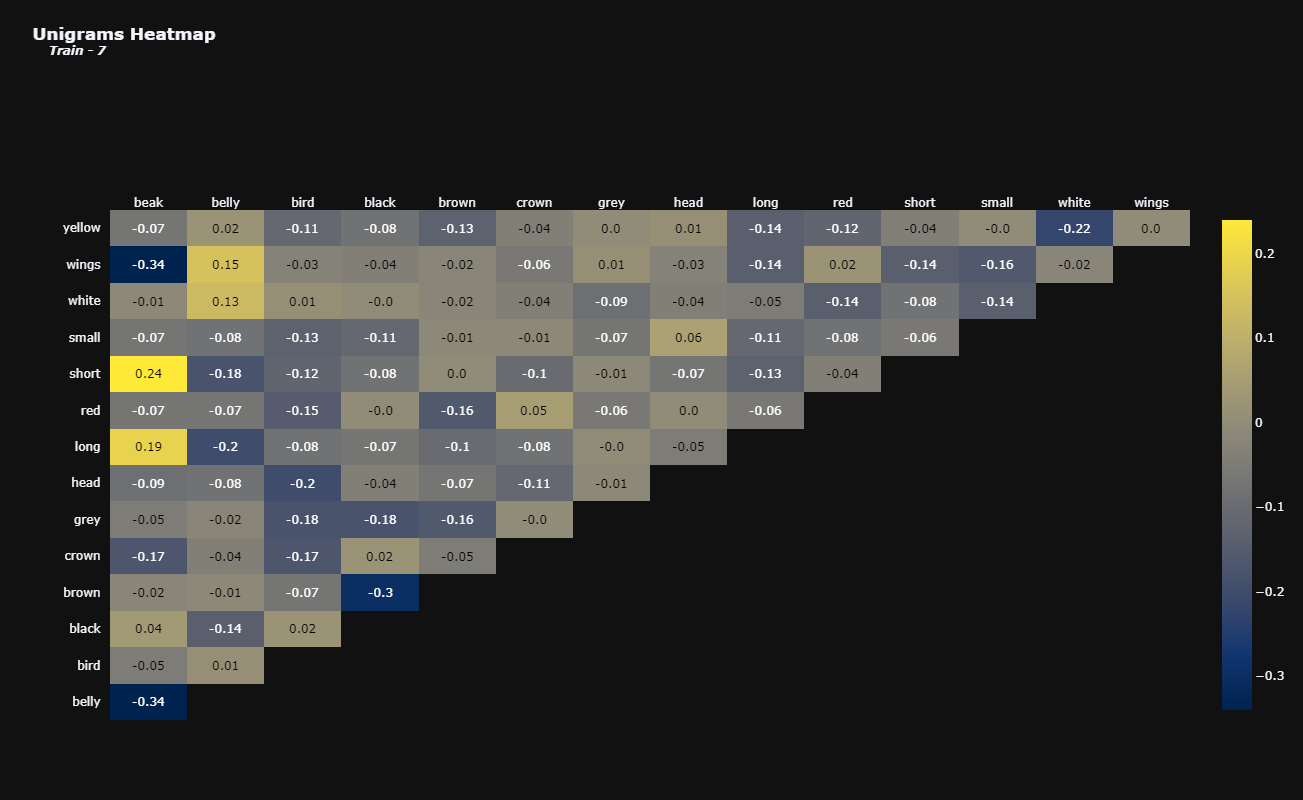

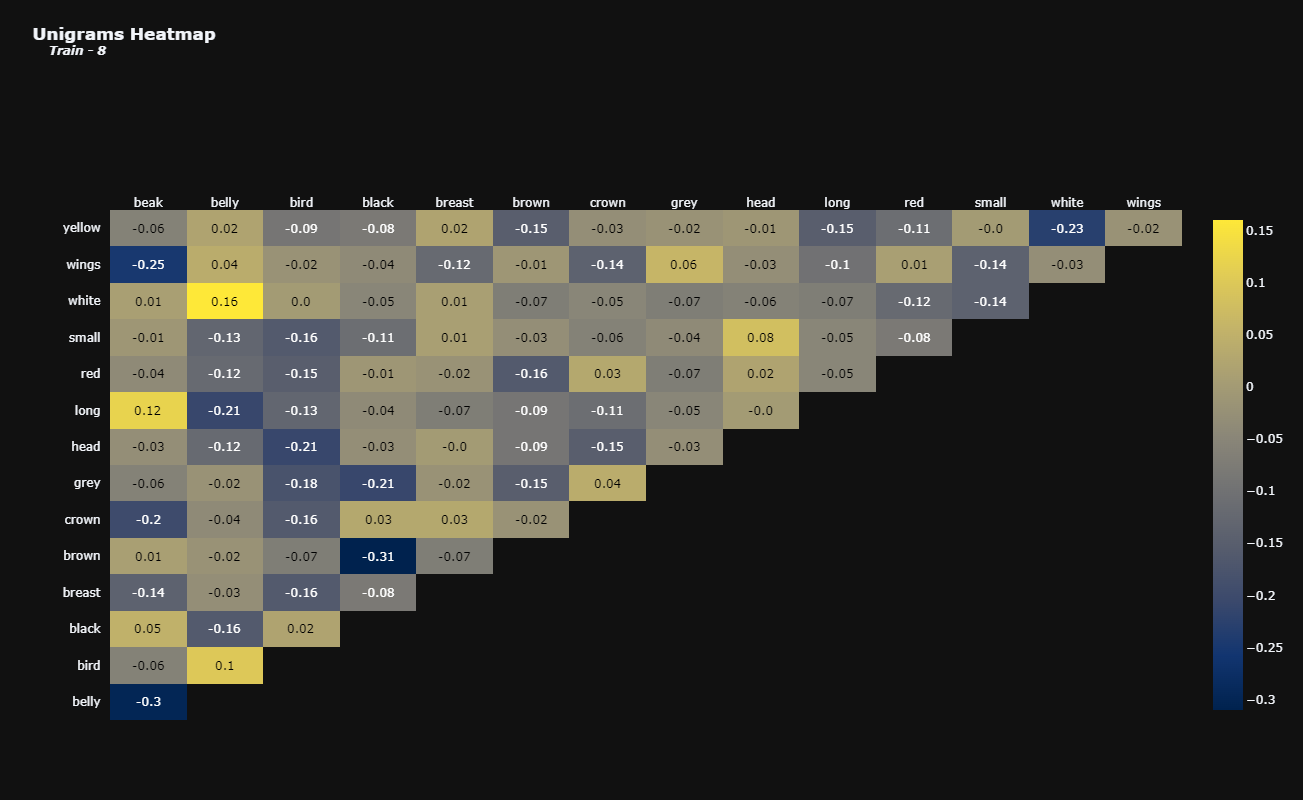

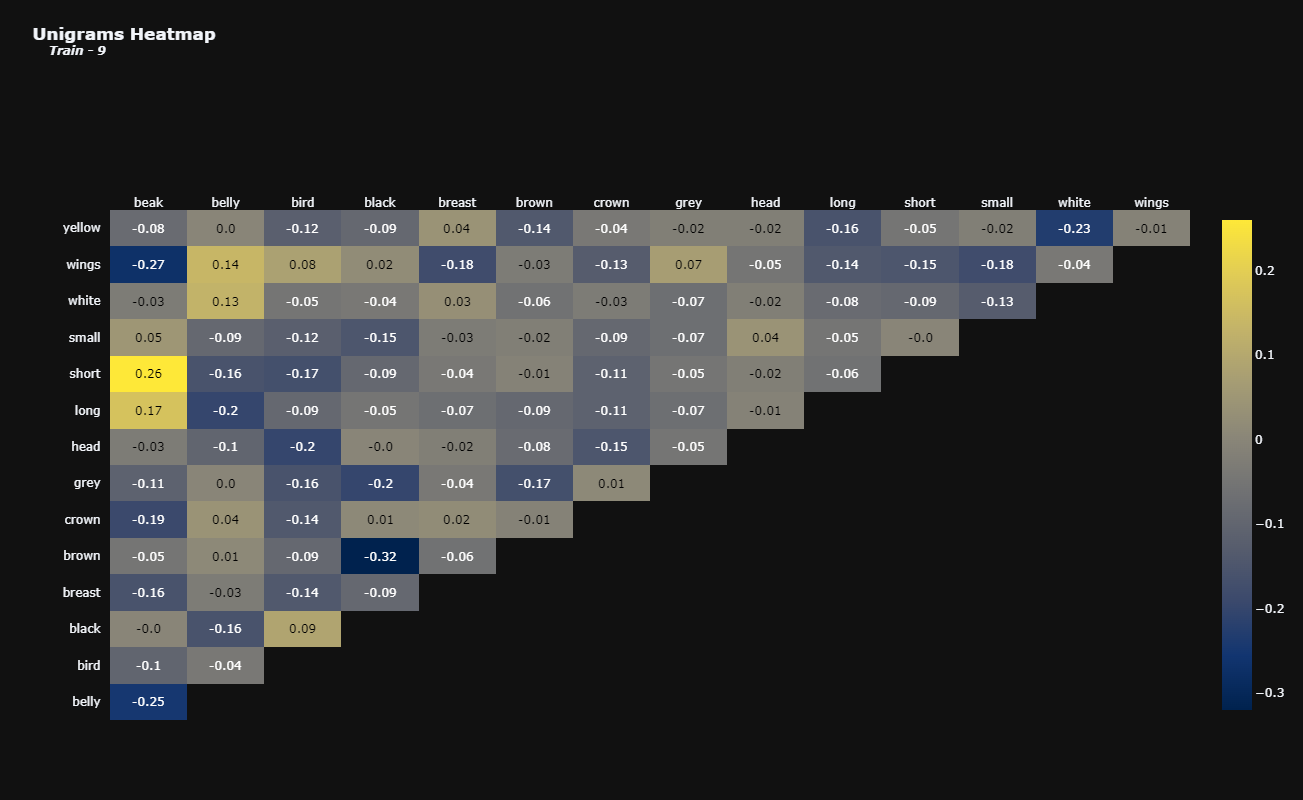

In [52]:
for i in categorical_features:
    df_tfidfvect=compute_tfidf(df[i], ngram_range=(1,1), max_features=15)
    plot_correlation(df_tfidfvect, 'Unigrams', f"Train - {i}", 800, 800, 12)
    print(" ")

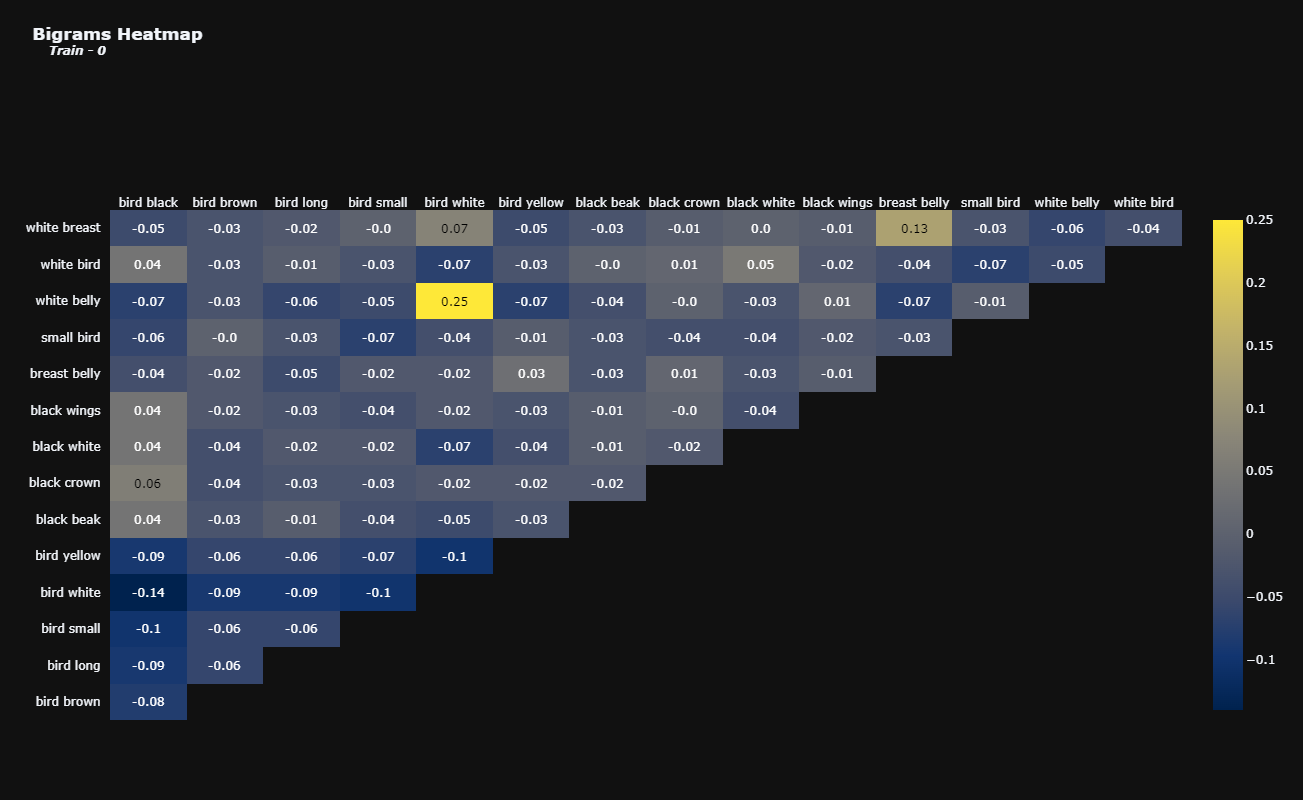

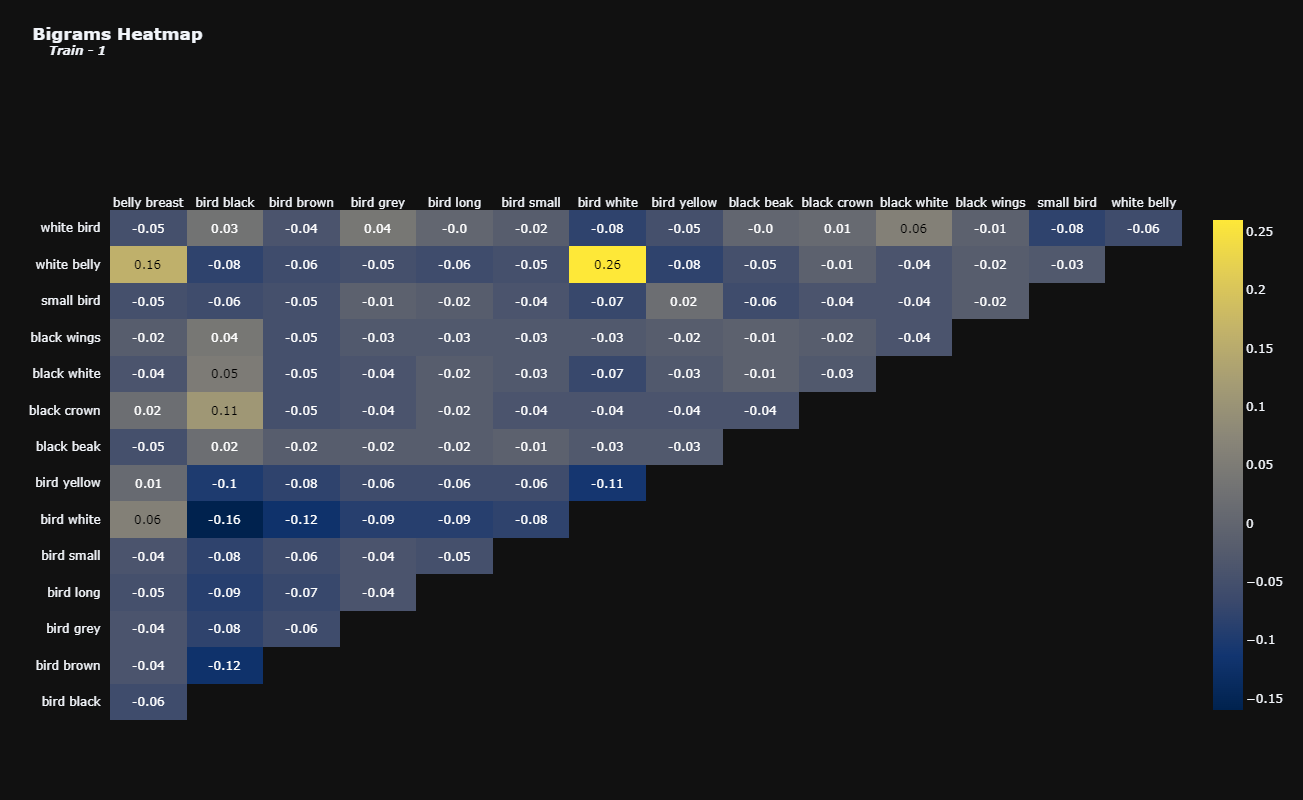

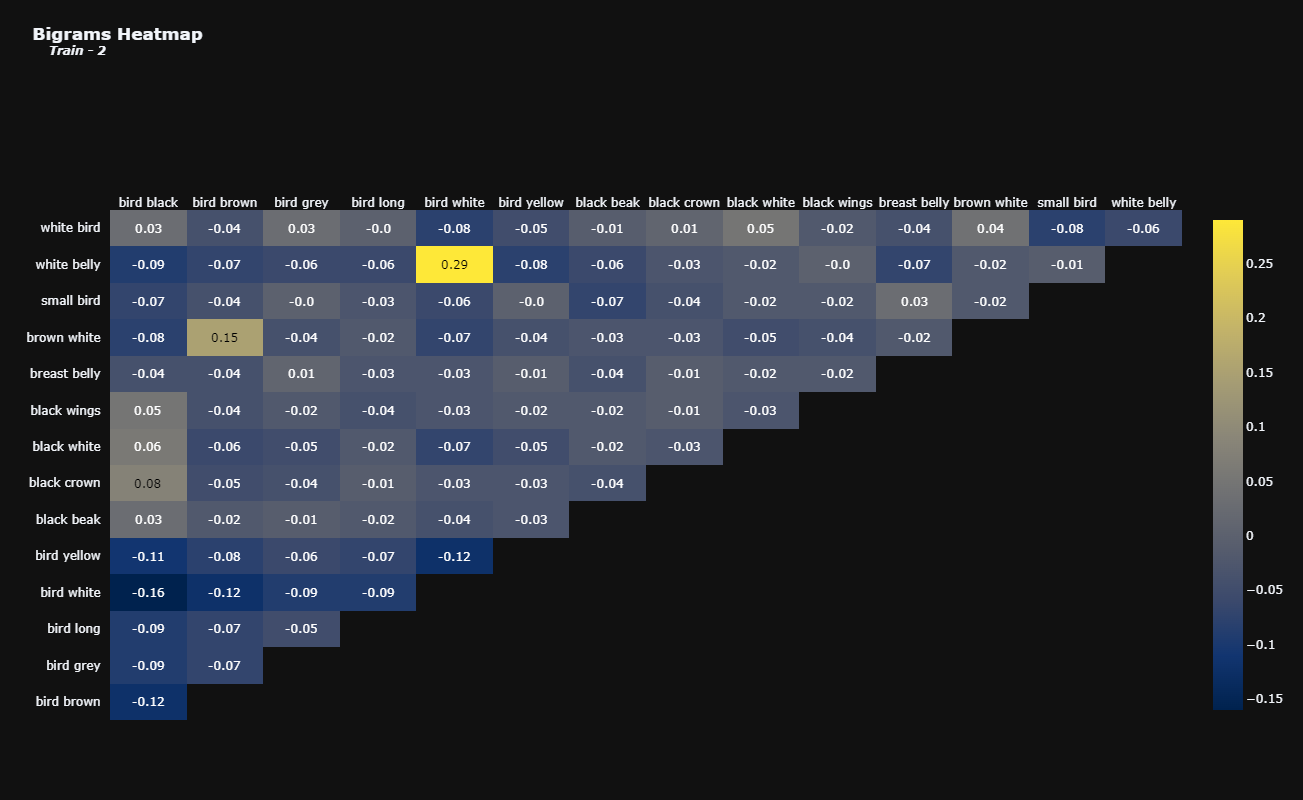

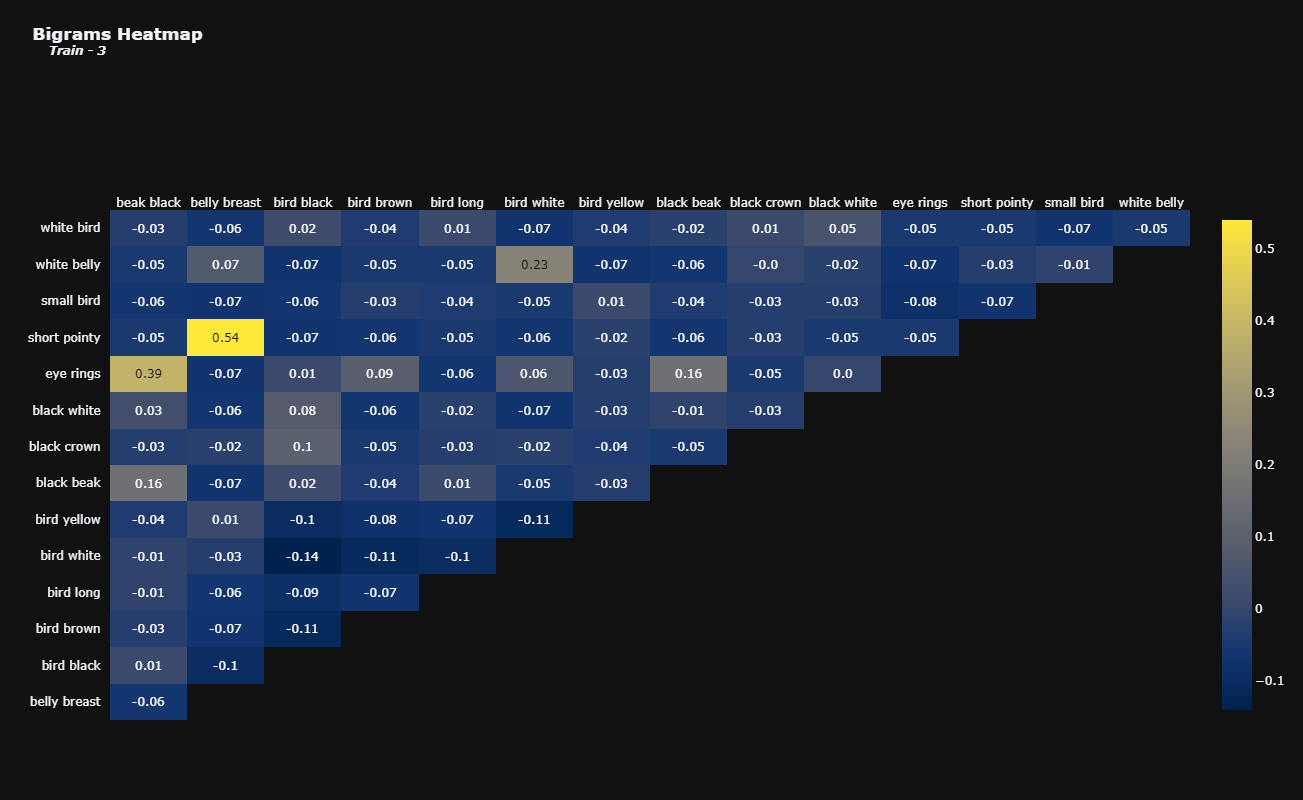

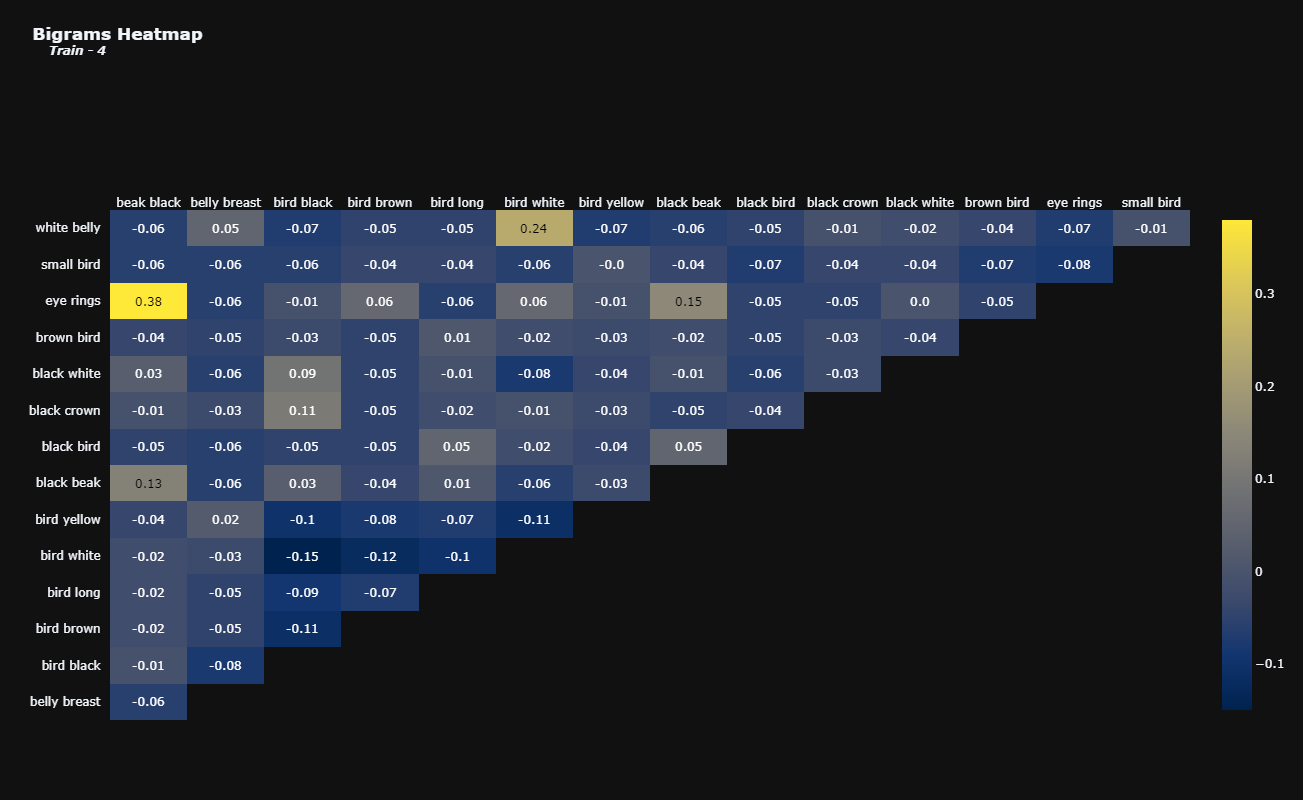

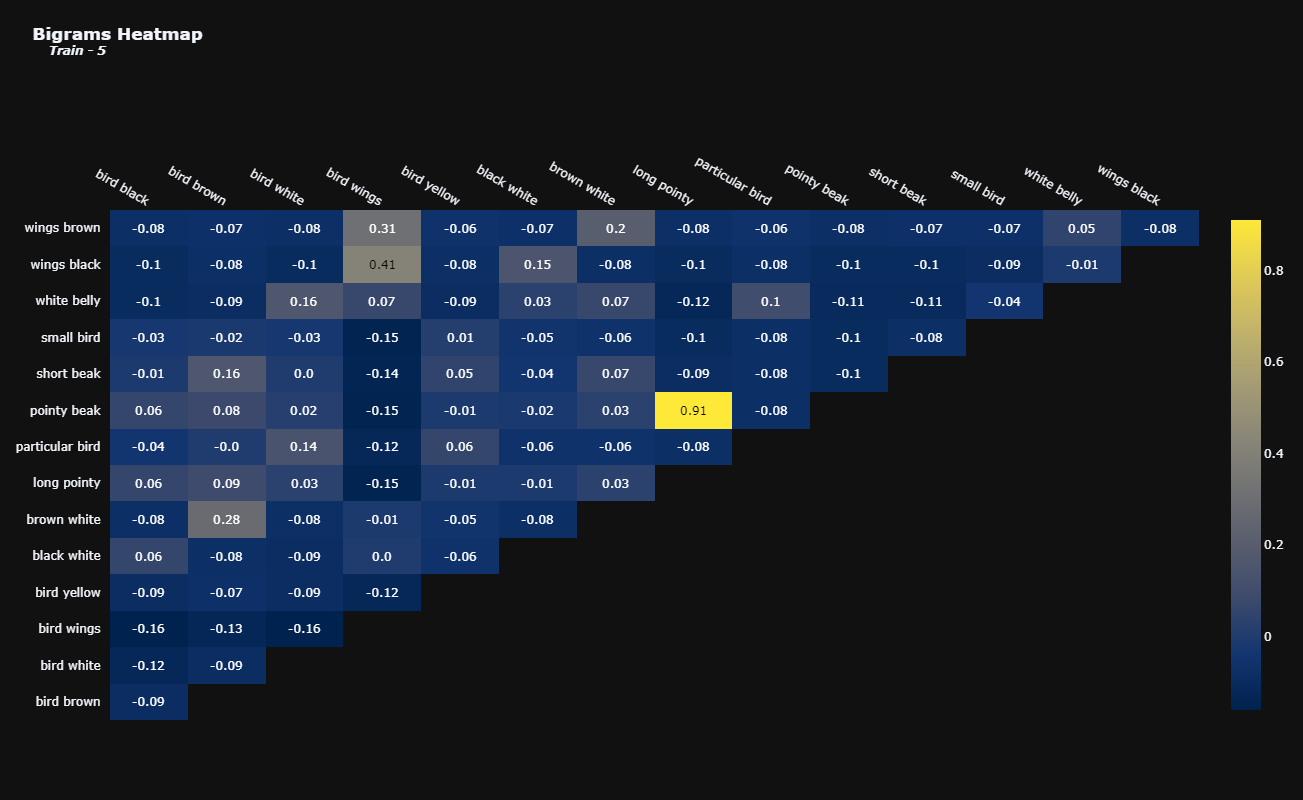

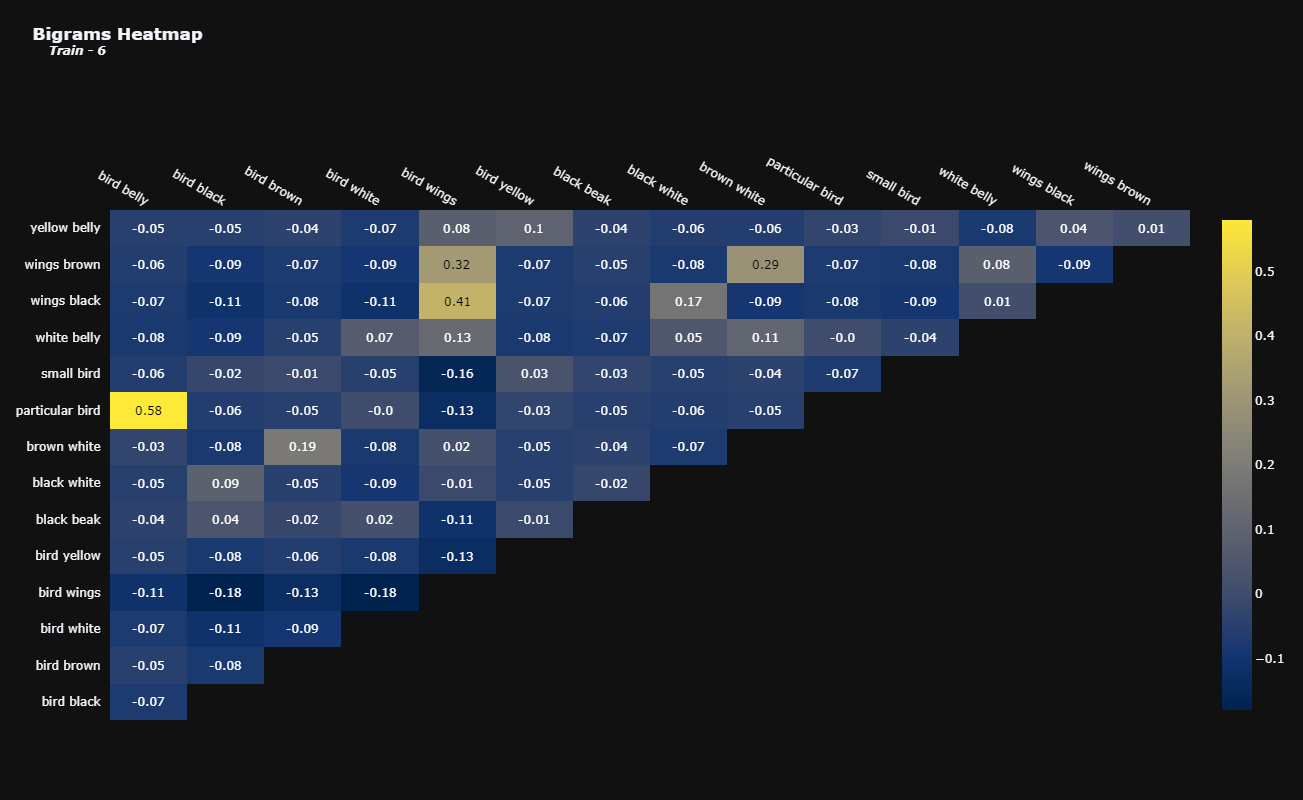

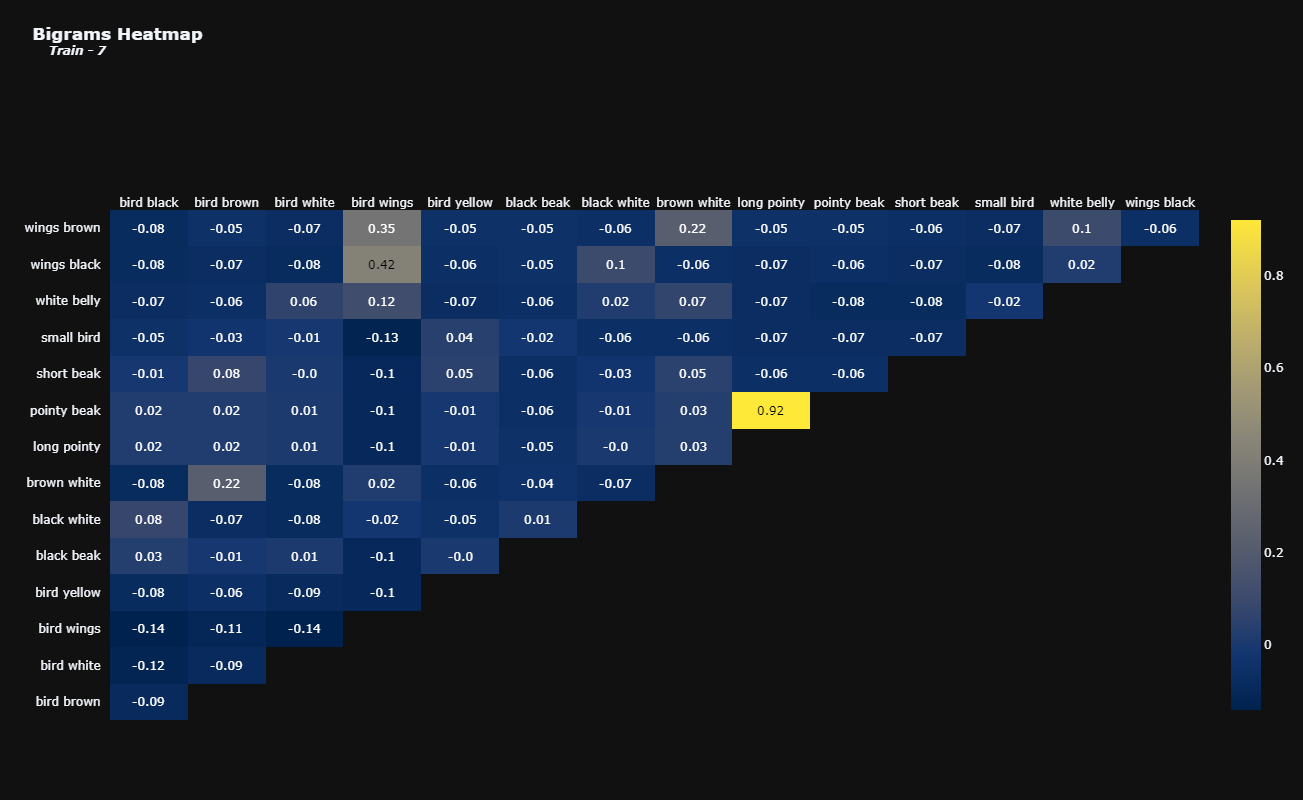

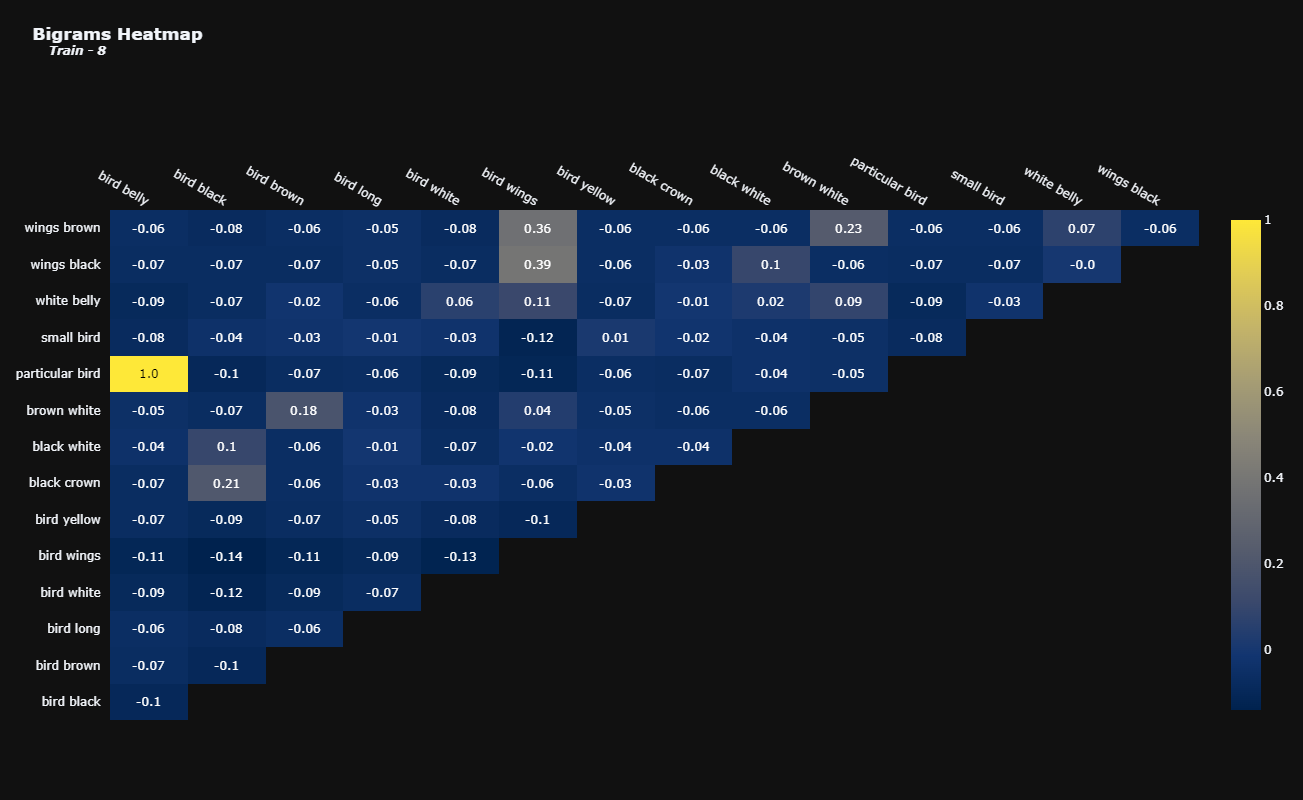

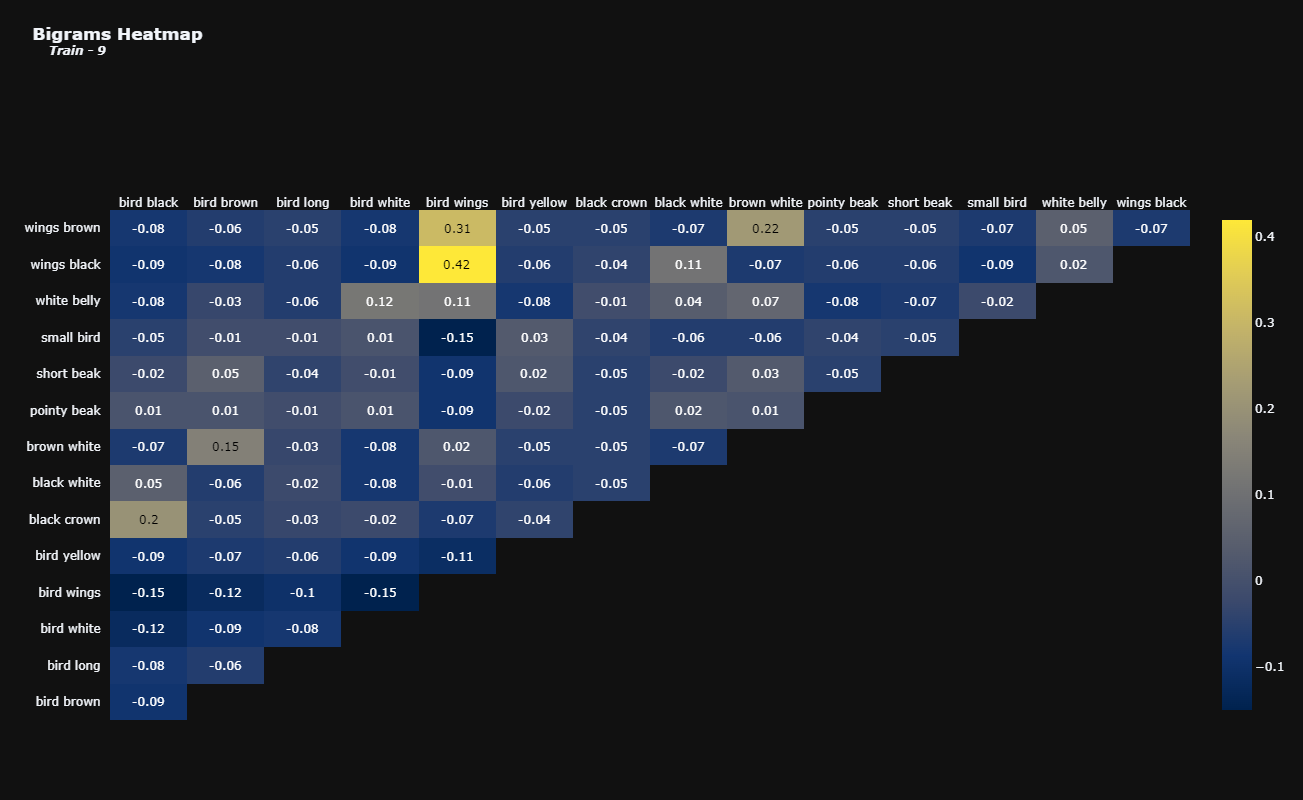

In [53]:
for i in categorical_features:
    df_tfidfvect=compute_tfidf(df[i], ngram_range=(2,2), max_features=15)
    plot_correlation(df_tfidfvect, 'Bigrams', f"Train - {i}", 800, 800, 12)
    print(" ")

# **The correlations are not extremely strong. Still, we can see some pairs that seem reasonable to be together**

In [ ]:
for i in categorical_features:
    df_tfidfvect=compute_tfidf(df[i], ngram_range=(2,2), max_features=15)
    plot_correlation(df_tfidfvect, 'Bigrams', f"Train - {i}", 800, 800, 12)
    print(" ")

In [54]:
df=df_test.drop(columns='File path',axis=1)

In [55]:
describe_df(df)

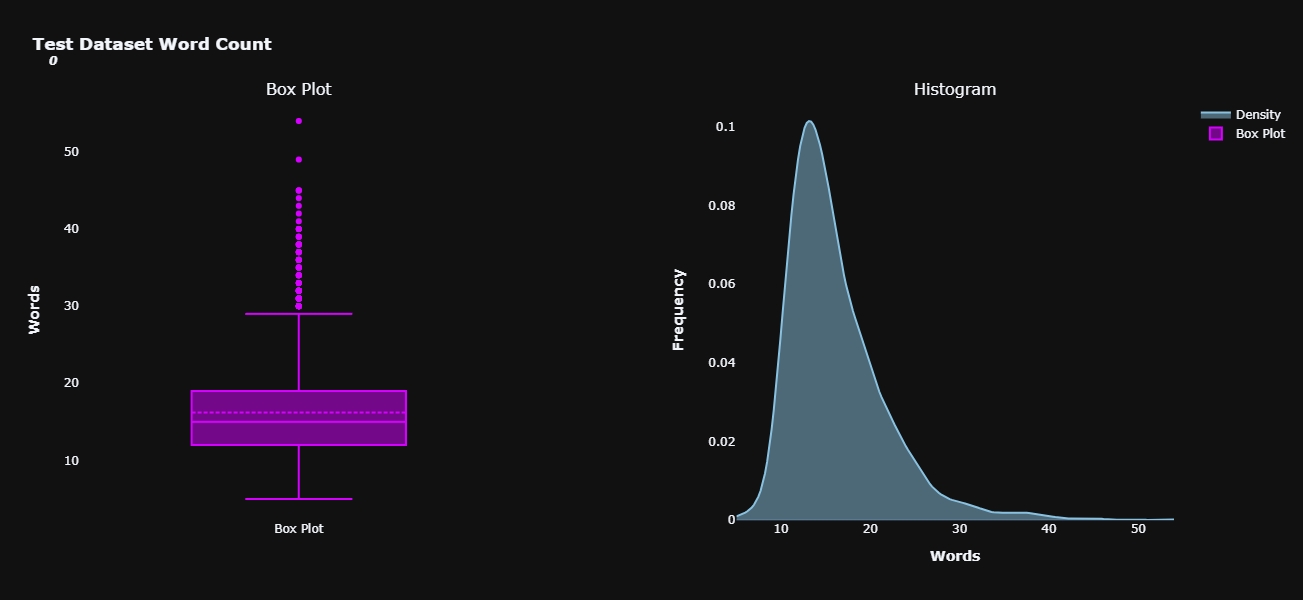

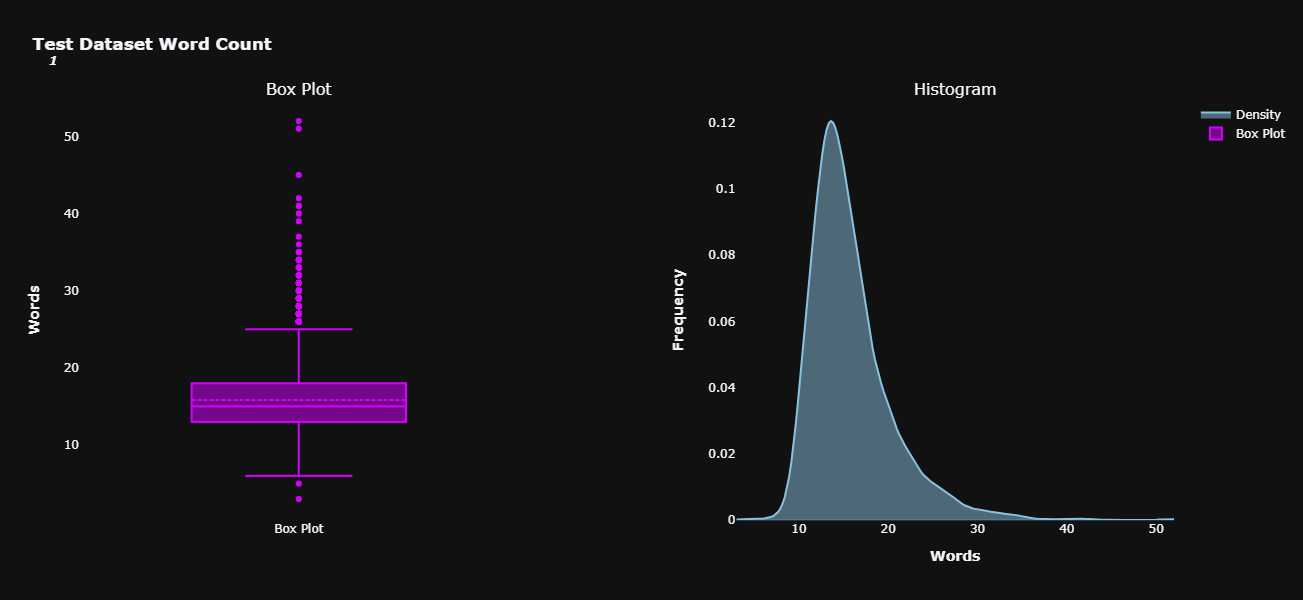

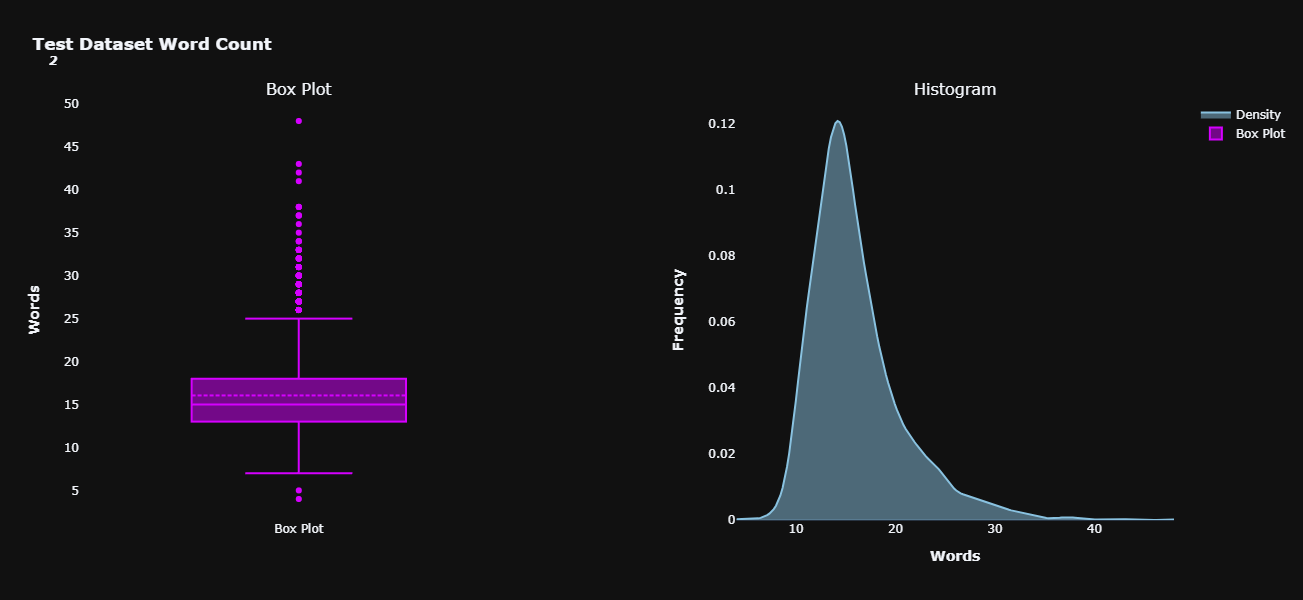

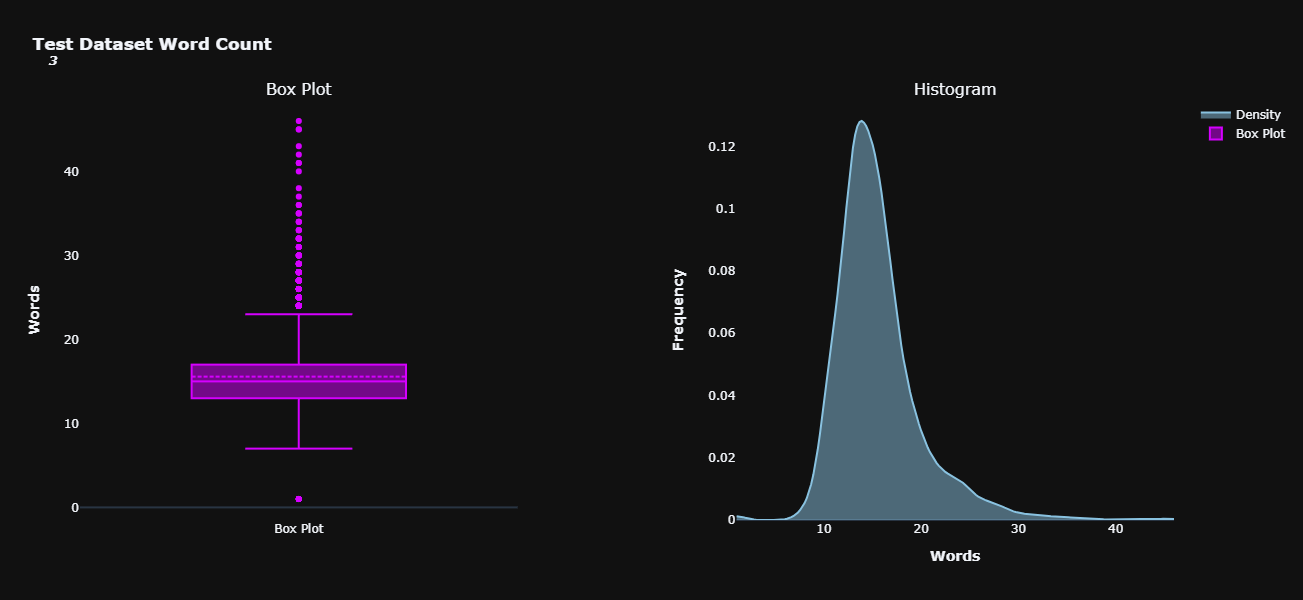

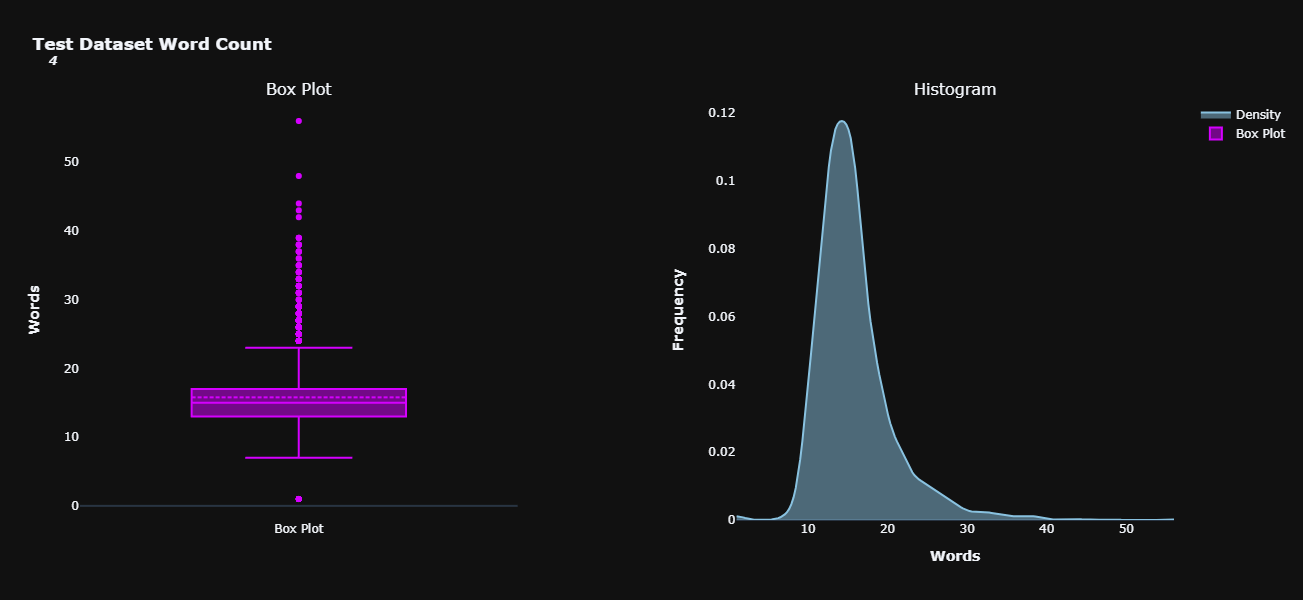

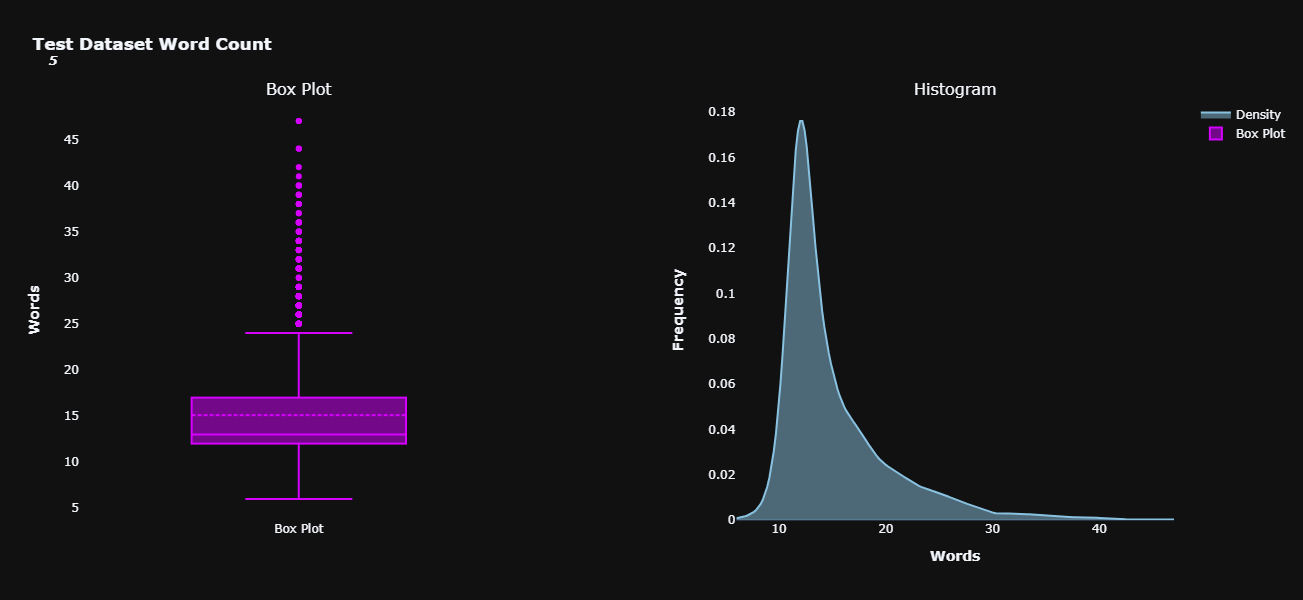

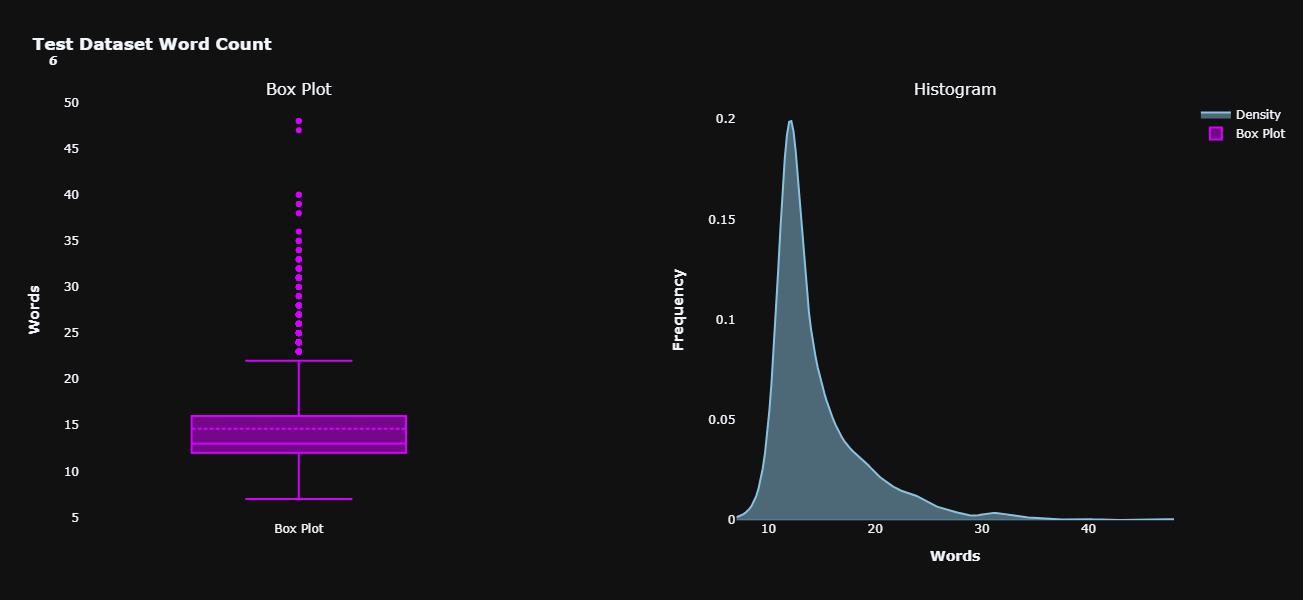

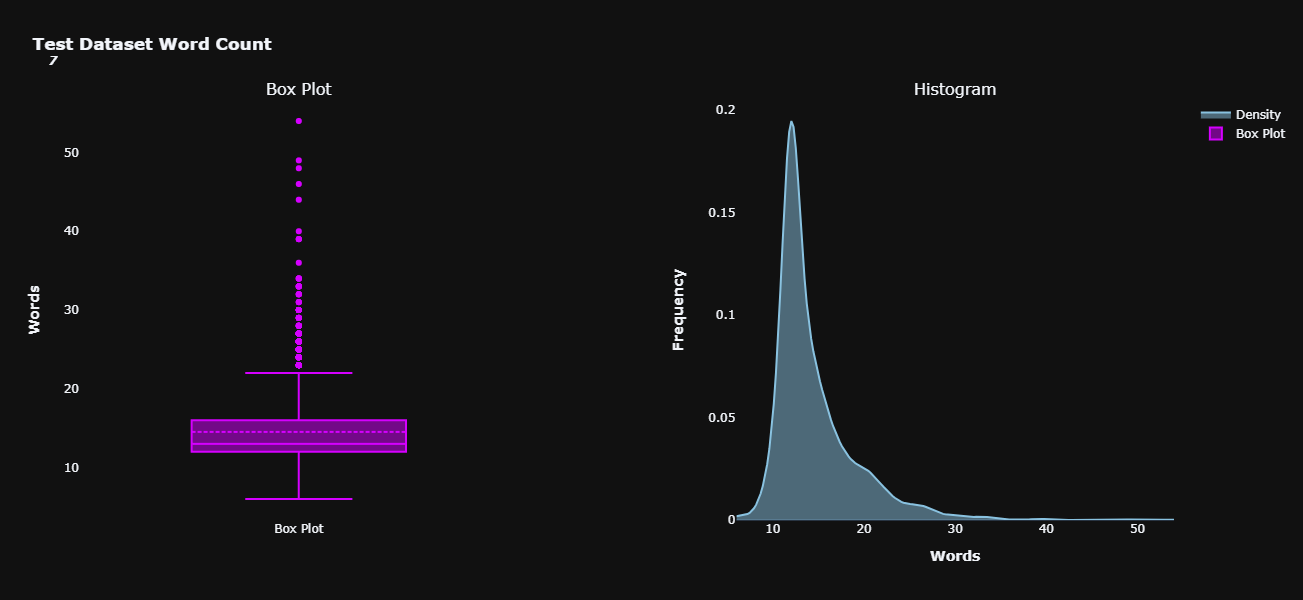

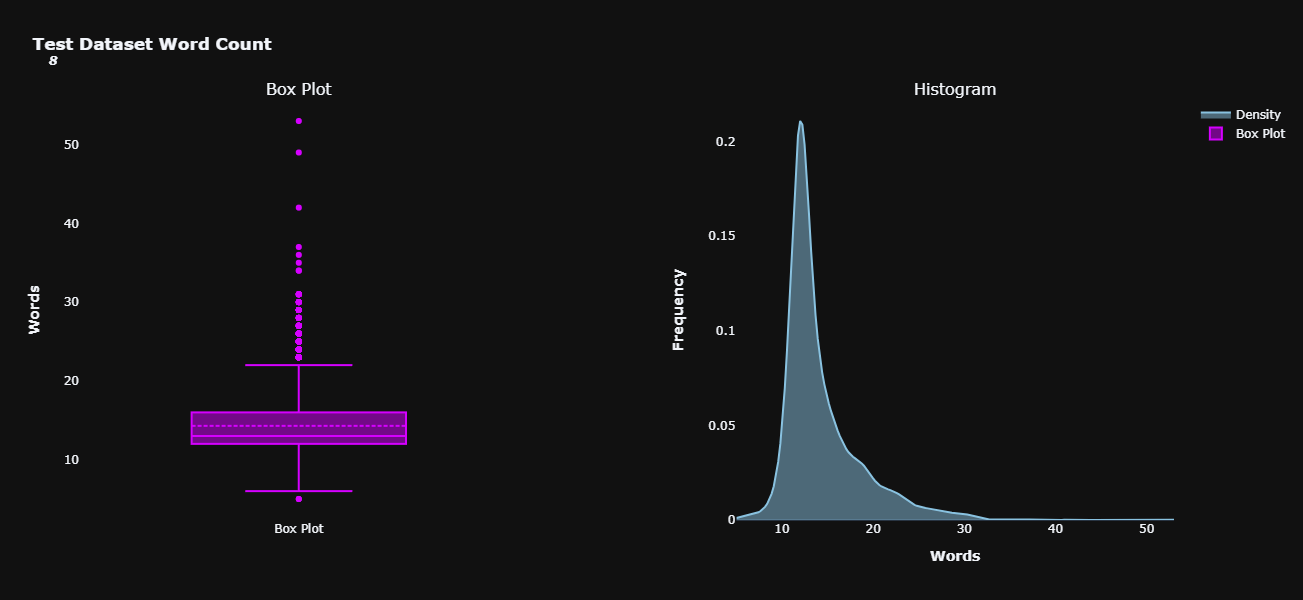

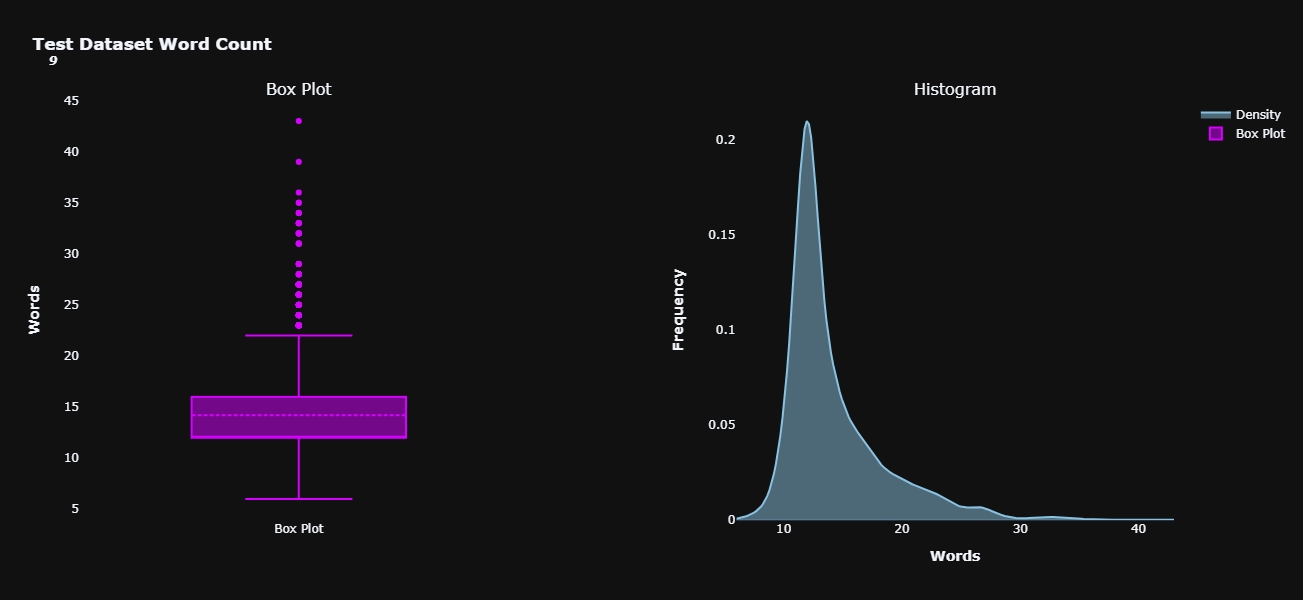

In [56]:
df_text_lenght = pd.DataFrame() # Creating an empty dataframe
for feat in categorical_features: # Iterating through features --> Dialogue & Summary
    df_text_lenght[feat] = df_test[feat].apply(lambda x: len(str(x).split())) #  Counting words for each feature

# Plotting histogram-boxplot
histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Test Dataset')

# **Both of Train and Test data with median Between 12:15 word**

# Removing "\n" at last evry caption

In [58]:
def remove_newlines(text):
    return re.sub(r'\n', '', text)

In [66]:
train_df=df_train.drop(columns='File path',axis=1)
test_df=df_test.drop(columns='File path',axis=1)

In [67]:
train_df = train_df.applymap(remove_newlines)

In [68]:
test_df = test_df.applymap(remove_newlines)

In [70]:
test_df[0][0]

'light tan colored bird with a white head and an orange beak.'

# **Lets Do Embedded**

In [74]:
model_name = "bert-large-uncased"  # Example BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [81]:
def toknizer(captions):
    captions_array=[]
    for i in captions:
        i=i.tolist()
        encoded_inputs = tokenizer(i, padding=True, truncation=True, return_tensors="tf")
        outputs = bert_model(**encoded_inputs)
        pooled_output = outputs.pooler_output
        pooled_output=pooled_output.numpy()
        captions_array.append(pooled_output)
    captions_array=np.array(captions_array)
    return captions_array

In [78]:
%%time
captions_train=train_df.to_numpy()
captions_test=test_df.to_numpy()

CPU times: user 39 µs, sys: 10 µs, total: 49 µs
Wall time: 54.4 µs


In [82]:
%%time
toknized_train_caption=toknizer(captions_train)
toknized_test_caption=toknizer(captions_test)

CPU times: user 1h 13min 40s, sys: 18.6 s, total: 1h 13min 58s
Wall time: 1h 13min 29s


# As we see this step take about an hour and a quarter

# Lets save those array as pickle

In [88]:
with open('/kaggle/working/embedded-train.pickle', 'wb') as f:
    # Serialize and save the array
    pickle.dump(toknized_train_caption, f)
with open('/kaggle/working/embedded-test.pickle', 'wb') as f:
    # Serialize and save the array
    pickle.dump(toknized_test_caption, f)

In [101]:
file='/kaggle/working/embedded-train.pickle'

In [106]:
def load_text_embeddings(text_embeddings):
	with open(text_embeddings, 'rb') as file:
		embeds = pickle.load(file, encoding='latin1')
		embeds = np.array(embeds)

	return embeds

In [116]:
embeds=load_text_embeddings(file)

In [119]:
embeds[0]

array([[-0.9838937 , -0.9506028 ,  0.9996856 , ..., -0.993866  ,
         0.9601986 , -0.9647317 ],
       [-0.9894114 , -0.95637923,  0.9961469 , ..., -0.5928771 ,
         0.8713182 , -0.80135566],
       [-0.7728898 , -0.88536775,  0.81742024, ...,  0.27275932,
         0.1242884 , -0.6179941 ],
       ...,
       [-0.99704593, -0.9841319 ,  0.9985936 , ..., -0.8086292 ,
         0.93611676, -0.86692524],
       [-0.99909824, -0.99215436,  0.9999263 , ..., -0.98240894,
         0.9834566 , -0.9659913 ],
       [-0.99447286, -0.9821353 ,  0.9989034 , ..., -0.91398036,
         0.9339204 , -0.92050743]], dtype=float32)